In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
import os
from joblib import Parallel, delayed


# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

from macd import MACD, DUAL_MACD,  compute_portfolio, run_macd_hyperparam_search, run_macd_hyperparam_search_with_regimes, generate_position
from momentum import SMA, EMA, evaluate_momentum_params, run_momentum_hyperparam_search
from performance_metrics import compute_performance_metrics
from supervised_learning import (
    SupervisedLearning,
    create_all_features,
    make_future_log_return,
    make_direction_label
)
from feature_engineering import create_all_features
from regime_clustering import compute_regime_clusters, assign_regimes

from utils import *

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lets_plot import *
LetsPlot.setup_html()

#  <a id = "top"> Table of Contents </a> 

## [Part 1 - Trading Strategies](#part1)

> Building trading stragies with spy as tradeable Assets

### [1.0 Buy and Hold](#part1_0)
### [1.1 Mean Reversion A - Dynamic SMA, Std, BB + Regime ATR & Volatility Clustering](#part1_1)
### [1.2 Mean Reversion B - Dynamic RSI + Regime ATR & Volatility Clustering](#part1_2)
### [1.3 Mean Reversion C - Dynamic SMA Percentage Distance, Candle Counts + Regime ATR & Volatility Clustering](#part1_3)
### [1.4 ML-Enhanced Adaptive SMA](#part14)
### [1.5 Adaptive Risk-Adjusted SMA](#part15)
### [1.6 Adaptive EMA](#part16)
### [1.7 Baseline MACD](#part17)
### [1.8 Adaptive MACD](#part18)
### [1.9 Volatility-Regime Adaptive MACD](#part19)
### [1.10 Dual MACD](#part110)
### [1.11 Daily Return Forecasting](#part111)


## [Part 2 - Results of Strategies](#part2)

> Visualize results of strategies

## [Part 3 - Executive Summary](#part3)

> Reviewing strategies and backtest results

### [3.1 Voting System](#part31)
### [3.2 Executive Summary](#part32)
### [3.3 Top 3 Strategies](#part33)

## [Part 4 - Self-Critique](#part4)

>  dissect and scrutinize our strategies through the lens of common biases and potential market shifts

## [Part 5 - Contribution Statement](#part5)

## <a id = "part1"></a><font color = blue> 👉 Part 1 - Trading strategies</font> [back to table of contents](#top) 

## Exploratory Data Analysis

In [4]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12

In [5]:
spy =\
(
    yf.
    download(
        "SPY",
        start = start_date,
        end = end_date
    )
)

spy.columns =\
(
    spy
    .columns
    .droplevel(1) # level 0 --> Price; level 1 --> Ticker
)

spy

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Date                                                                 
2006-11-01   95.973640   96.990457   95.875465   96.927346   83005600
2006-11-02   95.917519   96.078804   95.622993   95.728177   60693100
2006-11-03   95.749199   96.345269   95.104047   96.261122   71346400
2006-11-06   96.829132   96.969381   96.036712   96.043731   63303300
2006-11-07   97.200829   97.460289   96.773063   96.913312   63318900
...                ...         ...         ...         ...        ...
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500

[4788 rows x 5 columns]

In [6]:
df = spy.copy()

## Add Predictions

We transform future returns into predictive labels and train ML models to classify up/down movements, which later act as a filter for momentum trades.

In [7]:
Y_reg = make_future_log_return(spy, price_column="Close", horizon=1)
Y_clf = make_direction_label(Y_reg)   # 1 if up, 0 if down

In [8]:
X = create_all_features(
    spy,
    lagged_return_periods=[1,2,3,5,10],
    vol_periods=[20,60],
    sma_periods=[20,60],
    ema_periods=[10,30],
    rsi_periods=[10,30],
    stok_periods=[14],
    stod_periods=[3],
    roc_periods=[10],
    atr_periods=[5,14]
)


In [9]:
data = pd.concat([Y_clf, X], axis=1).dropna()

Y = data[Y_clf.name]
X = data[X.columns]

SL = SupervisedLearning()

X_train, X_test, Y_train, Y_test = SL.sequential_split(X, Y, train_frac=0.75)

Sequential Split: 3546 train / 1183 test samples


In [10]:
results = SL.run_all_classifiers(X_train, Y_train, X_test, Y_test)
results

Logistic: accuracy=0.5571
RandomForest: accuracy=0.4658
GradientBoosting: accuracy=0.4590
KNN_Classifier: accuracy=0.4937


Model  Accuracy
0          Logistic  0.557058
1      RandomForest  0.465765
2  GradientBoosting  0.459003
3    KNN_Classifier  0.493660

In [11]:
result = SL.tune_probability_threshold(
    model = SL.get_classifier_by_name('Logistic'),
    X_train = X_train,
    y_train = Y_train,
    X_test  = X_test,
    y_test  = Y_test,
    thresholds = np.arange(0.50, 0.80, 0.01),
    return_metric="sharpe"
)

result["best_threshold"]
result["threshold_cv_results"].head()


Best Threshold = 0.500
threshold          0.500000
train_sharpe      17.033682
test_sharpe       16.736577
train_accuracy     0.554992
test_accuracy      0.557058
Name: 0, dtype: float64


threshold  train_sharpe  test_sharpe  train_accuracy  test_accuracy
0       0.50     17.033682    16.736577        0.554992       0.557058
1       0.51     16.642944    16.344413        0.556966       0.556213
2       0.52     15.774099    15.694373        0.553299       0.546915
3       0.53     14.351283    15.069640        0.547941       0.540997
4       0.54     12.609164    14.173703        0.540609       0.534235

In [12]:
clf = result["model"]
best_th = result["best_threshold"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Probability SPY goes UP
p_train = clf.predict_proba(X_train_scaled)[:, 1]
p_test  = clf.predict_proba(X_test_scaled)[:, 1]
train_pred = (p_train > best_th).astype(int)
test_pred  = (p_test > best_th).astype(int)

In [13]:
df.loc[X_train.index, "ml_prob"] = p_train
df.loc[X_train.index, "ml_signal"] = train_pred

df.loc[X_test.index, "ml_prob"] = p_test
df.loc[X_test.index, "ml_signal"] = test_pred

# df = df.bfill() # just to complet the ml prob and ml signal accoridng

In [14]:
df.tail(5)

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300   
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400   
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900   
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400   
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500   

Price        ml_prob  ml_signal  
Date                             
2025-11-06  0.605947        1.0  
2025-11-07  0.599819        1.0  
2025-11-10  0.576945        1.0  
2025-11-11  0.610358        1.0  
2025-11-12  0.608380        1.0

### Passive Returns

In [15]:
split_idx = int(len(df) * 0.75)

df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

In [16]:
df_train = generate_passive_returns(df_train)
df_test = generate_passive_returns(df_test)

In [17]:
plot_returns(
    df=df_train.reset_index(),
    y='Training Returns'
)

In [18]:
plot_returns(
    df=df_test.reset_index(),
    y='Testing Returns'
)

<Axes: xlabel='Date'>

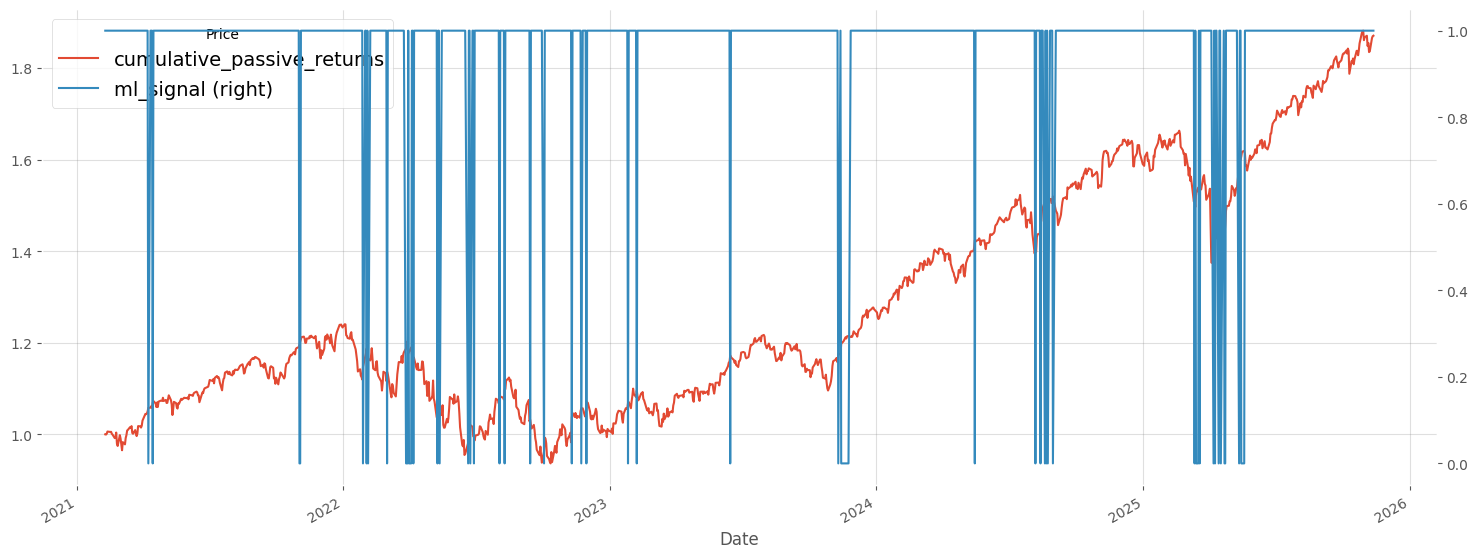

In [19]:
(
    df_test[['cumulative_passive_returns','ml_signal']]
    .plot(secondary_y = "ml_signal",
          figsize = [18, 7]
         )
)

# Individual Strategies

In [20]:
starting_capital = 100_000.0
combined_results = []
df_test

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2021-02-09  365.365631  365.964835  364.354510  364.766427   35551100   
2021-02-10  365.206421  367.266149  362.790948  367.116348   59154400   
2021-02-11  365.796204  366.713724  363.352645  366.292407   42913300   
2021-02-12  367.603241  367.846643  364.916223  364.991138   50593300   
2021-02-16  367.284851  369.035634  366.563961  368.839004   50972400   
...                ...         ...         ...         ...        ...   
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300   
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400   
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900   
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400   
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500   

Price        ml_prob  ml_signal  passive_returns  cumulative_passive_returns  
Date                                                                          
2021-02-09  0.561384        1.0              NaN                    1.000000  
2021-02-10  0.542515        1.0        -0.000436                    0.999564  
2021-02-11  0.551160        1.0         0.001614                    1.001178  
2021-02-12  0.533409        1.0         0.004928                    1.006124  
2021-02-16  0.553148        1.0        -0.000866                    1.005253  
...              ...        ...              ...                         ...  
2025-11-06  0.605947        1.0        -0.010787                    1.834628  
2025-11-07  0.599819        1.0         0.000984                    1.836434  
2025-11-10  0.576945        1.0         0.015484                    1.865091  
2025-11-11  0.610358        1.0         0.002287                    1.869360  
2025-11-12  0.608380        1.0         0.000556                    1.870400  

[1197 rows x 9 columns]

## <a id = "part1_0"></a> 1.0 Buy and Hold [back to table of contents](#top)

In [21]:
buy_and_hold = \
(
    compute_performance_metrics(
        log_returns=df_test['passive_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Buy and Hold'
    )
)
print(buy_and_hold)

               CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Buy and Hold  0.141       0.173         0.245          0.85          1.403   

              Calmar Ratio  Final Portfolio Value  Cumulative Return  
Buy and Hold         0.574             187040.035               1.87  


In [22]:
combined_results.append(buy_and_hold)

## <a id = "part1_1"></a> 1.1 Mean Reversion A - Dynamic SMA, Std, BB + Regime ATR & Volatility Clustering [back to table of contents](#top)

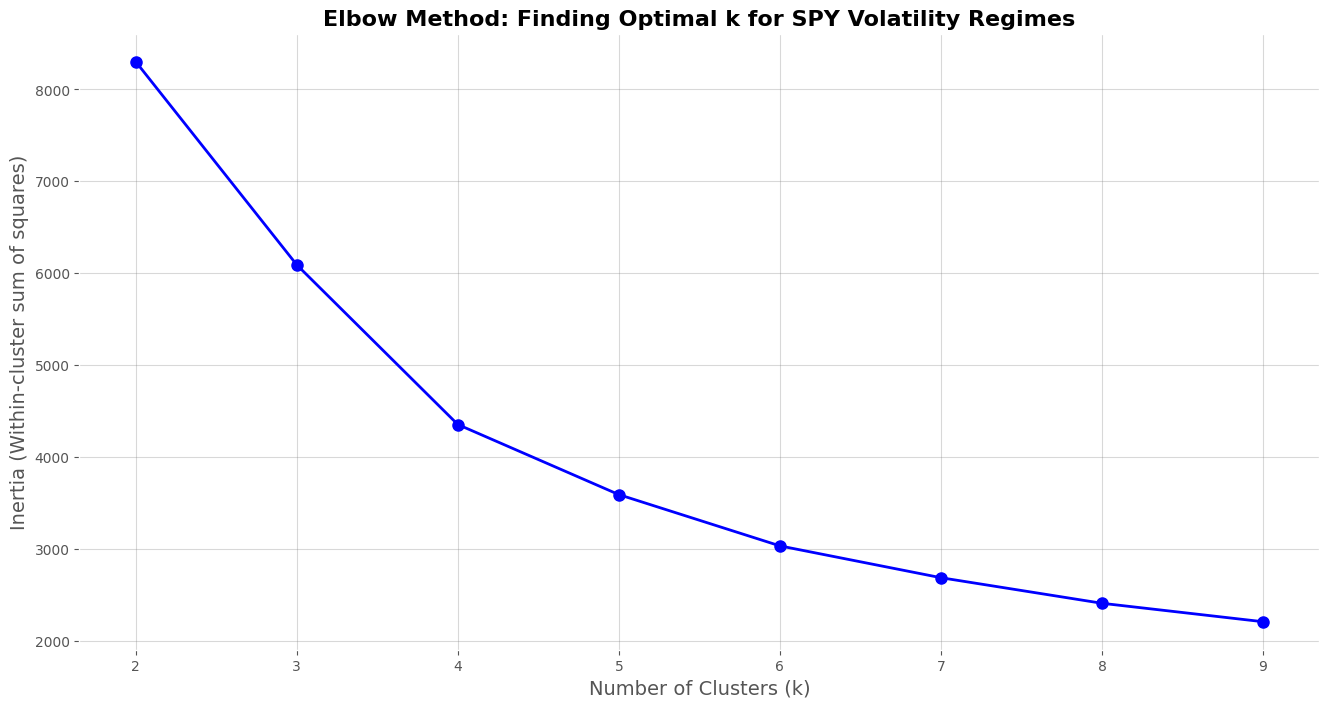

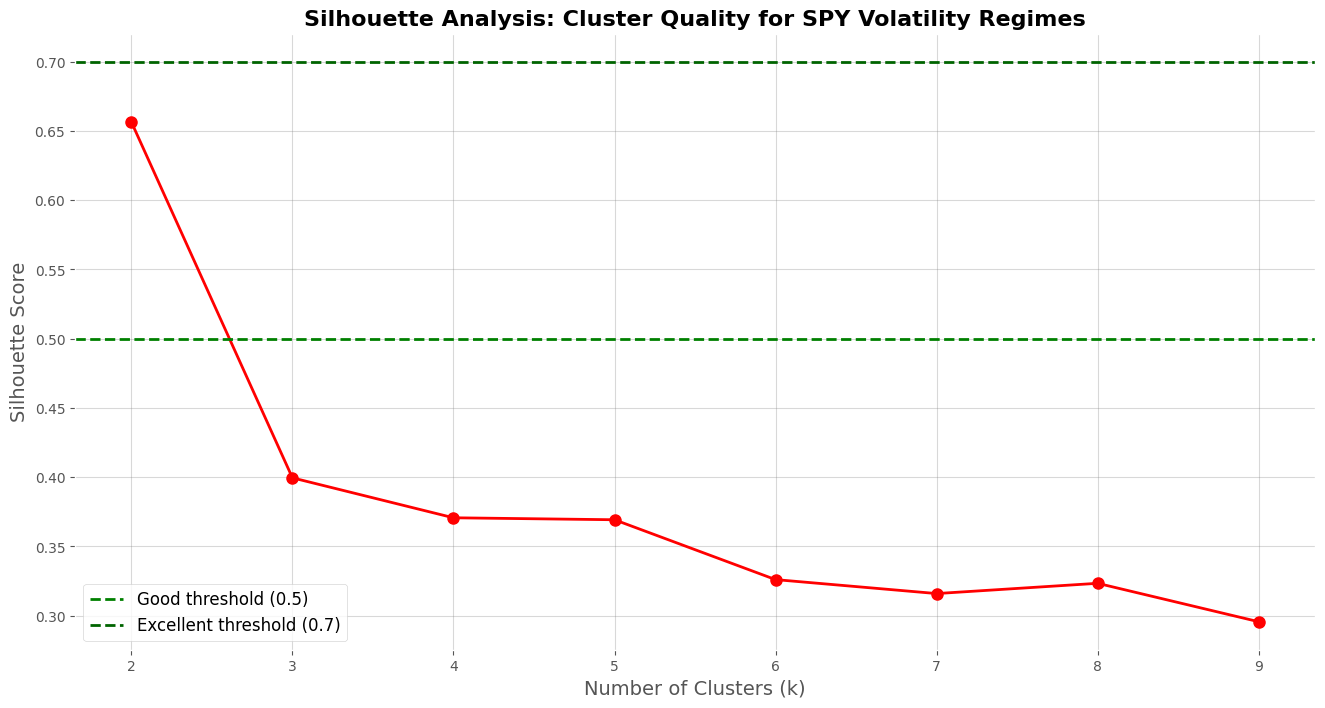

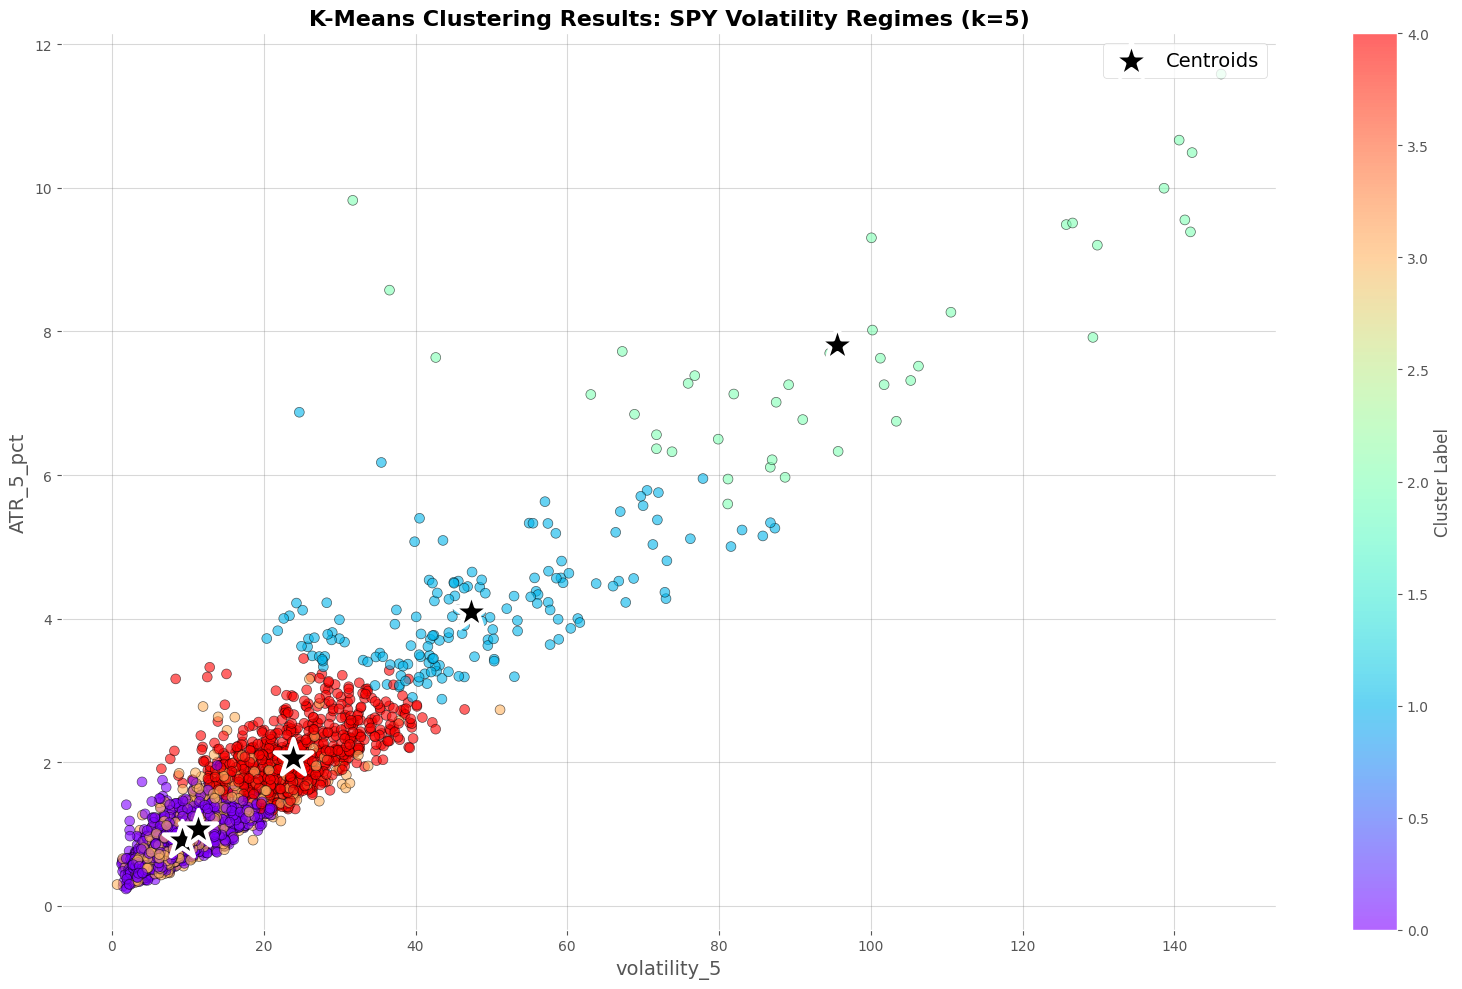

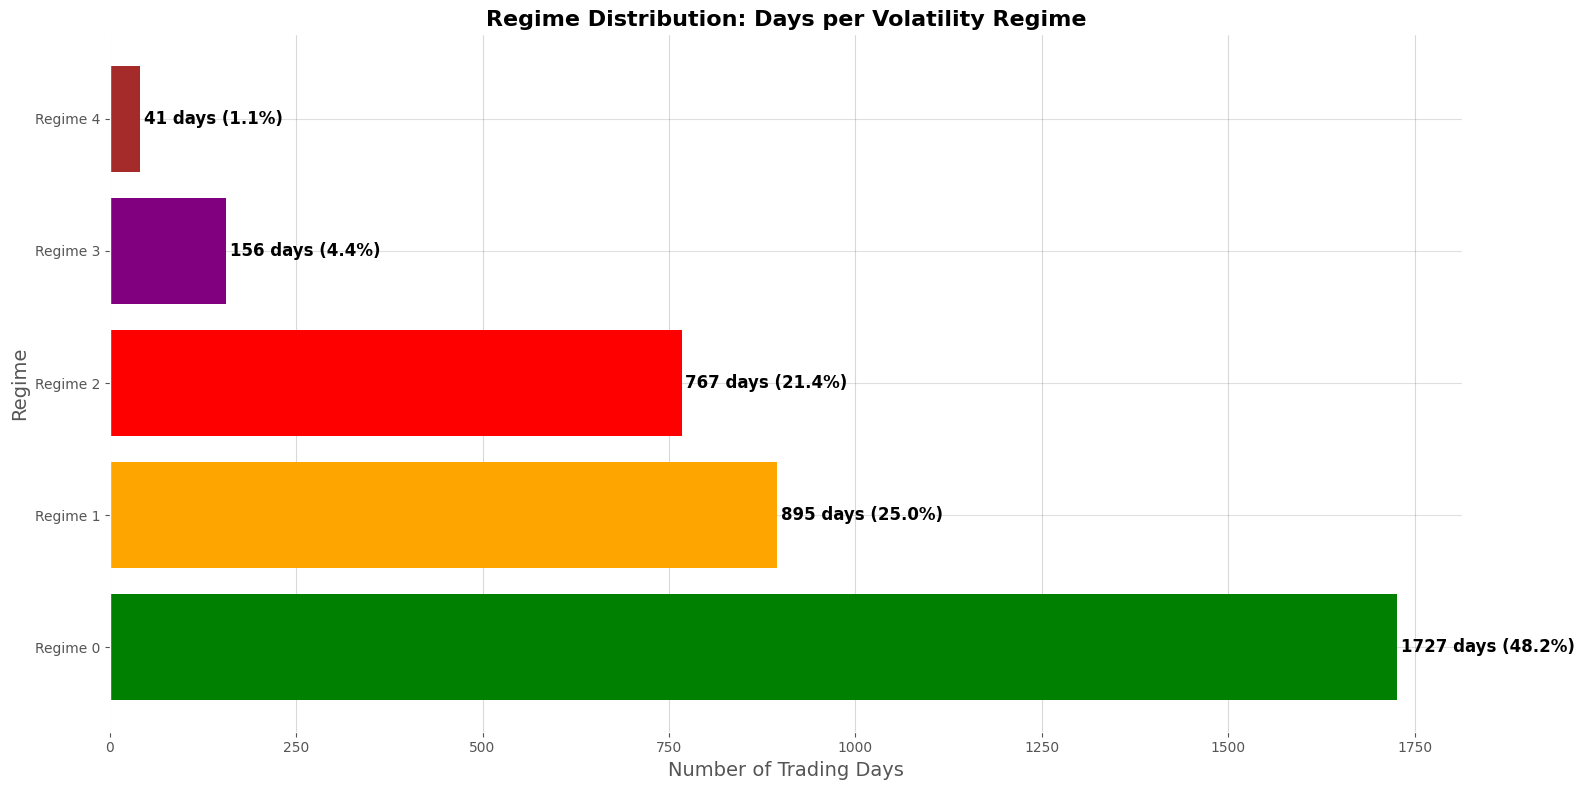


LOADING REGIME PARAMETERS FROM CSV FILES (FROM TRAINING DATA)

GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY (USING TRAINING DATA)
✅ Loaded Very Low Vol (Calm): Window=5, Z_Long=-0.6, Z_Short=3.2
✅ Loaded Low Vol (Stable): Window=8, Z_Long=-0.8, Z_Short=2.2
✅ Loaded Medium Vol (Normal): Window=5, Z_Long=-1.1, Z_Short=1.7
✅ Loaded High Vol (Elevated): Window=7, Z_Long=-0.9, Z_Short=2.8
✅ Loaded Very High Vol (Crisis): Window=25, Z_Long=-0.8, Z_Short=2.5

✅ Loaded parameters for 5 regimes from CSV

UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA

Training Data Period:
  Start Date: 2006-11-01
  End Date:   2021-02-08
  Total Days: 3591

Testing strategy on FULL training data with regime transitions...

Regime Parameters Being Used:
  Very Low Vol (Calm): window=5, z_long=-0.6, z_short=3.2
  Low Vol (Stable): window=8, z_long=-0.8, z_short=2.2
  Medium Vol (Normal): window=5, z_long=-1.1, z_short=1.7
  High Vol (Elevated): window=7, z_long=-0.9, z_short=2.8
  Very High Vol (Cr

Metric   Train    Test
0  Total Return (%)  258.96   87.59
1          CAGR (%)    9.37   14.14
2      Sharpe Ratio    0.67    1.23
3  Max Drawdown (%)  -29.97  -11.60
4      Total Trades     310     115


GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY


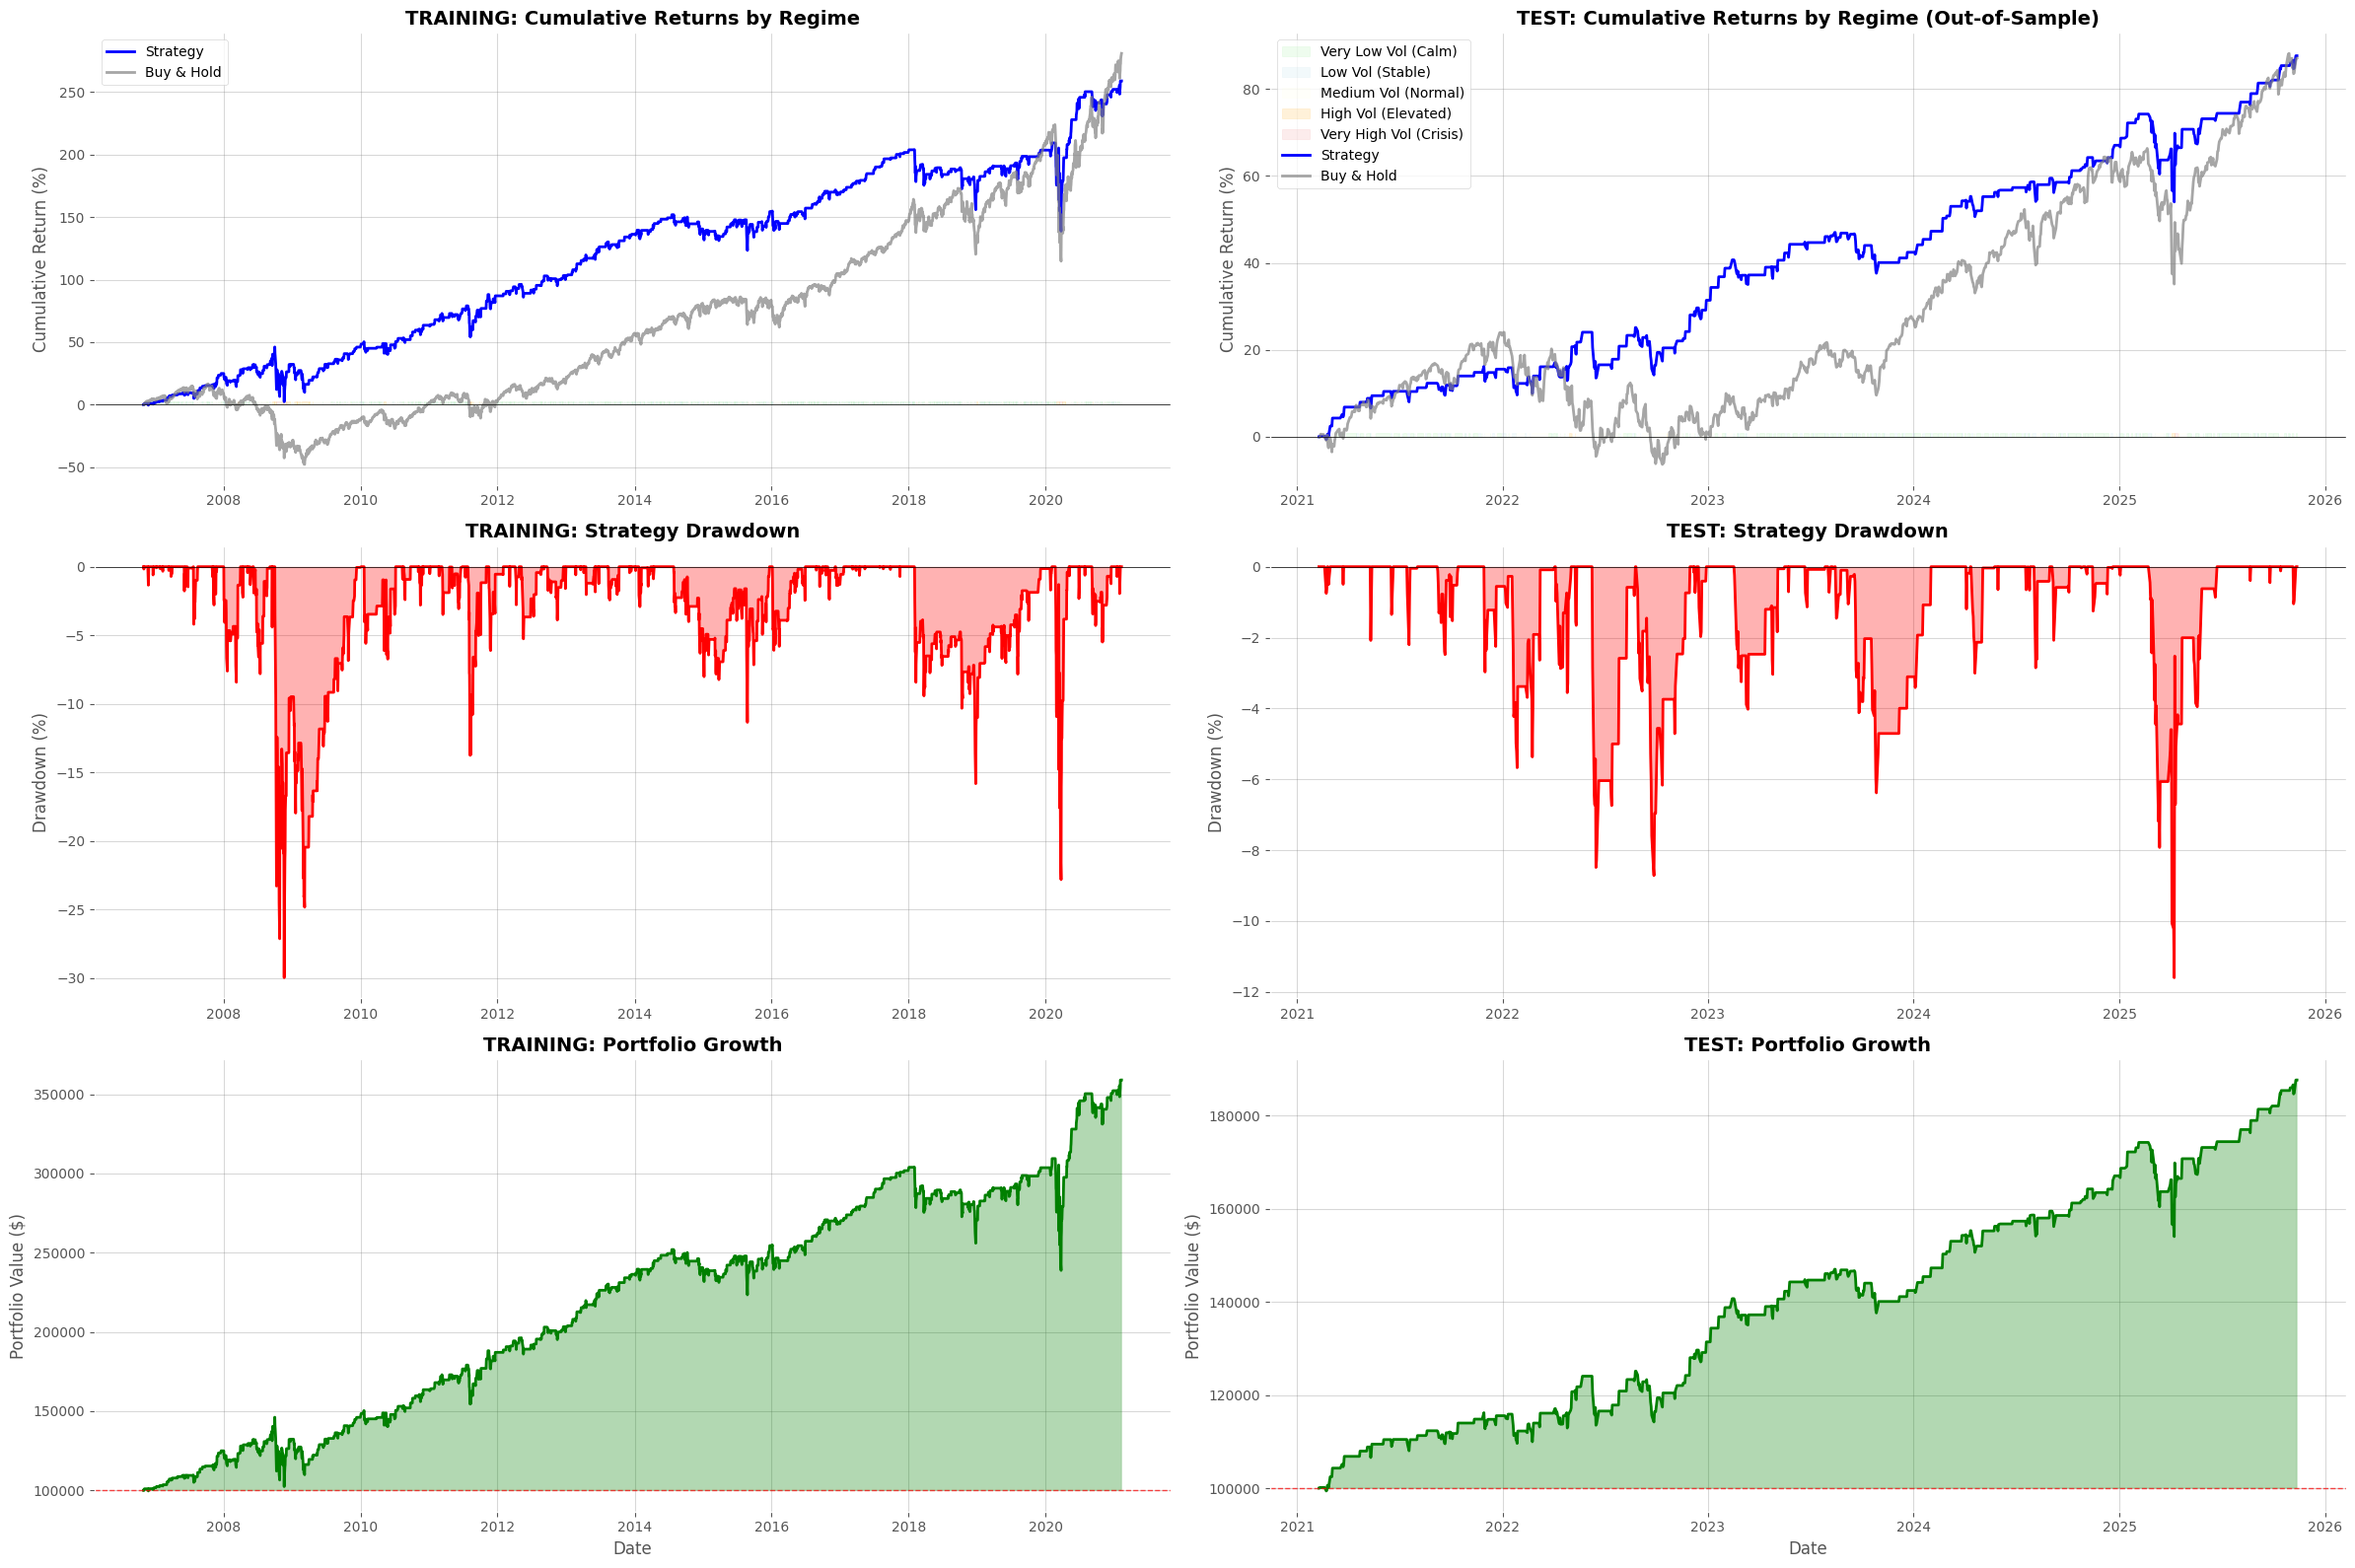


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                           258.96              87.59             280.95              87.04
Max Drawdown (%)                           -29.97             -11.60             -55.19             -24.50
Final Portfolio ($)            $       358,959.57 $       187,595.00 $       380,947.35 $       187,040.10

TEST DATA: Entry/Exit Signals with Regime Background (Year by Year)

Test data spans 5 years: 2021 - 2025
Generating 5 separate visualizations...


YEAR 2021
Trading days: 227
Date range: 2021-02-09 to 2021-12-31


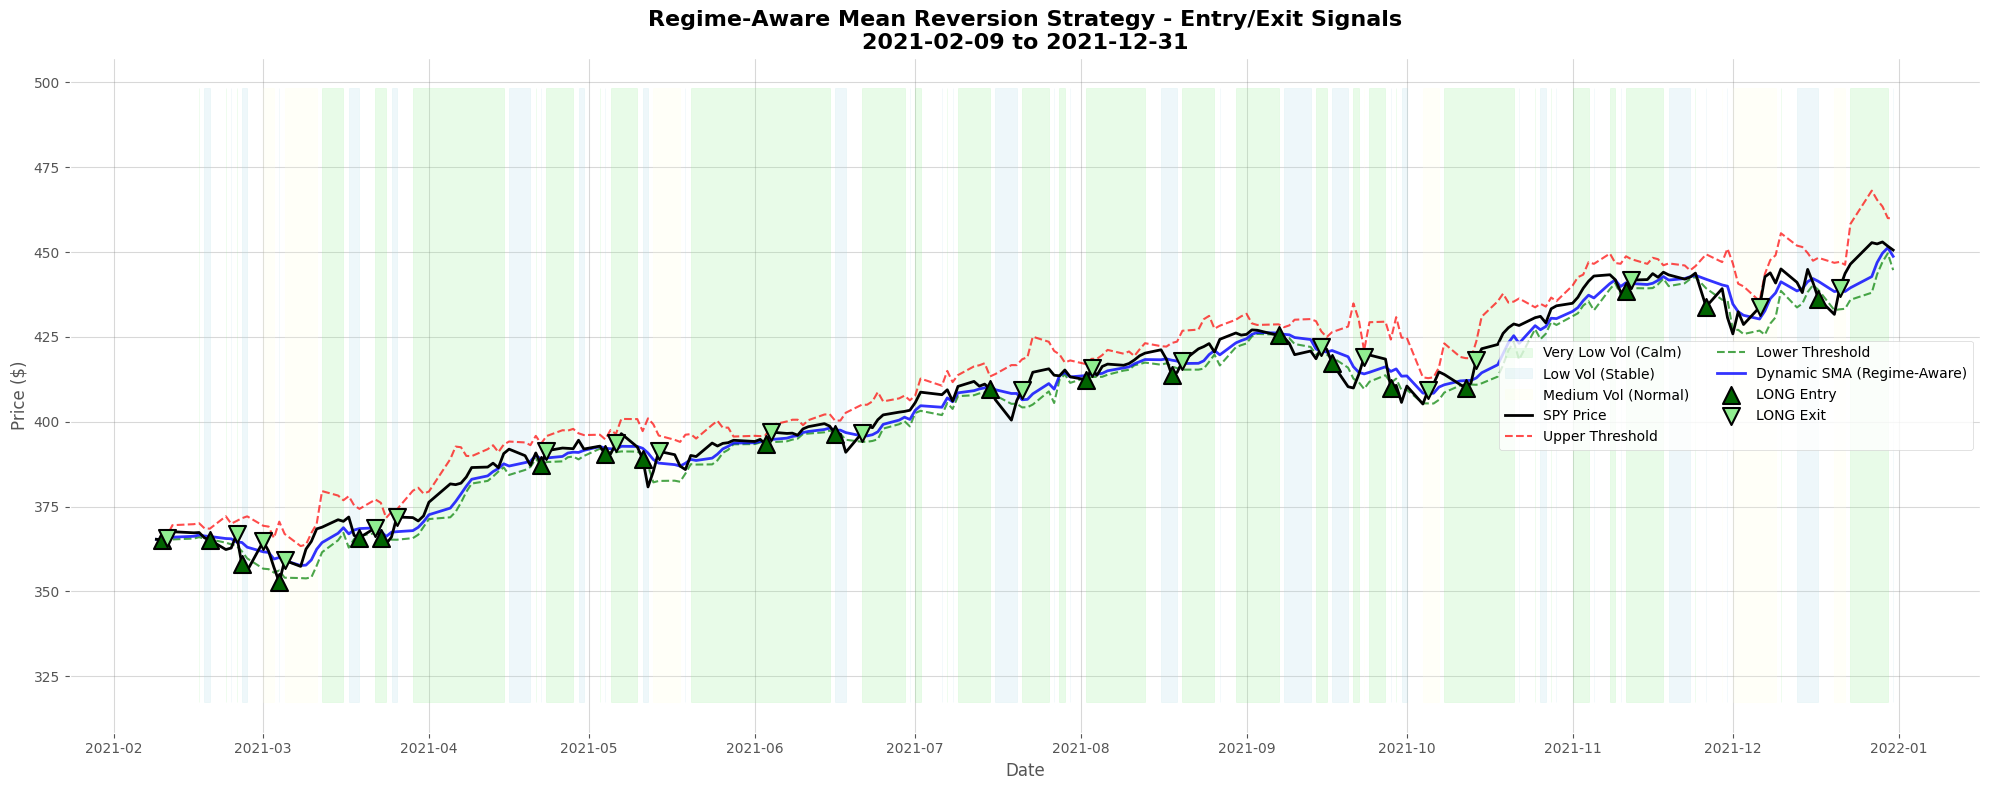


SIGNAL SUMMARY
Long Entries:  21
Long Exits:    21
Short Entries: 0
Short Exits:   0
Total Signals: 42

YEAR 2022
Trading days: 251
Date range: 2022-01-03 to 2022-12-30


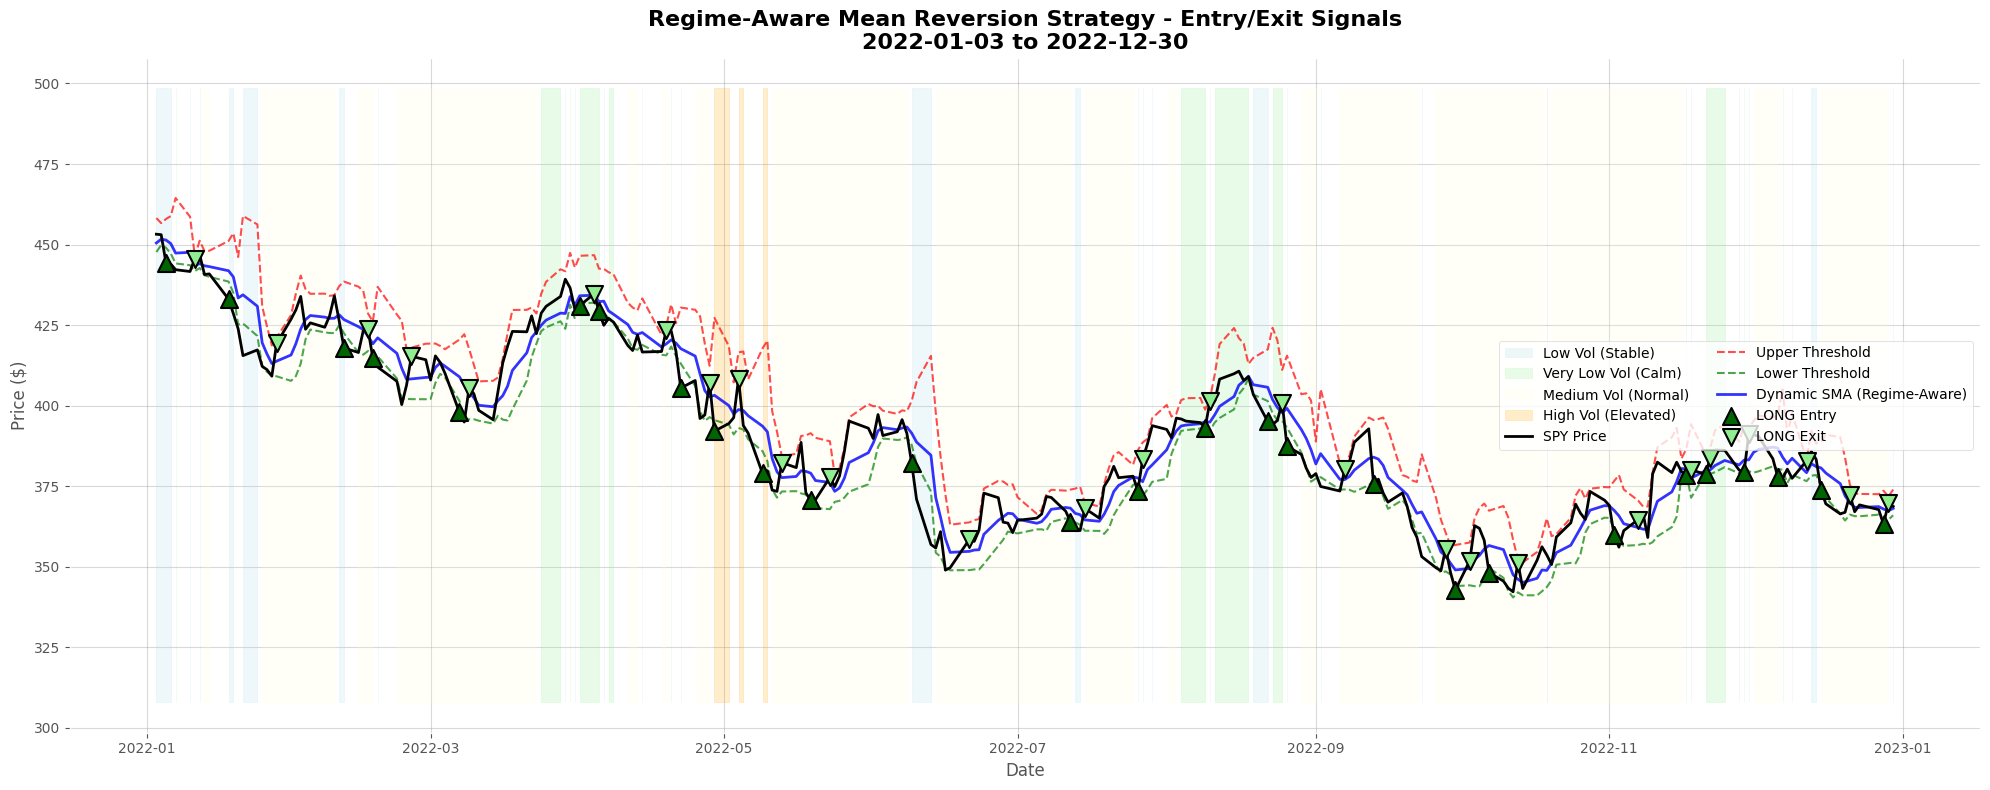


SIGNAL SUMMARY
Long Entries:  27
Long Exits:    27
Short Entries: 0
Short Exits:   0
Total Signals: 54

YEAR 2023
Trading days: 250
Date range: 2023-01-03 to 2023-12-29


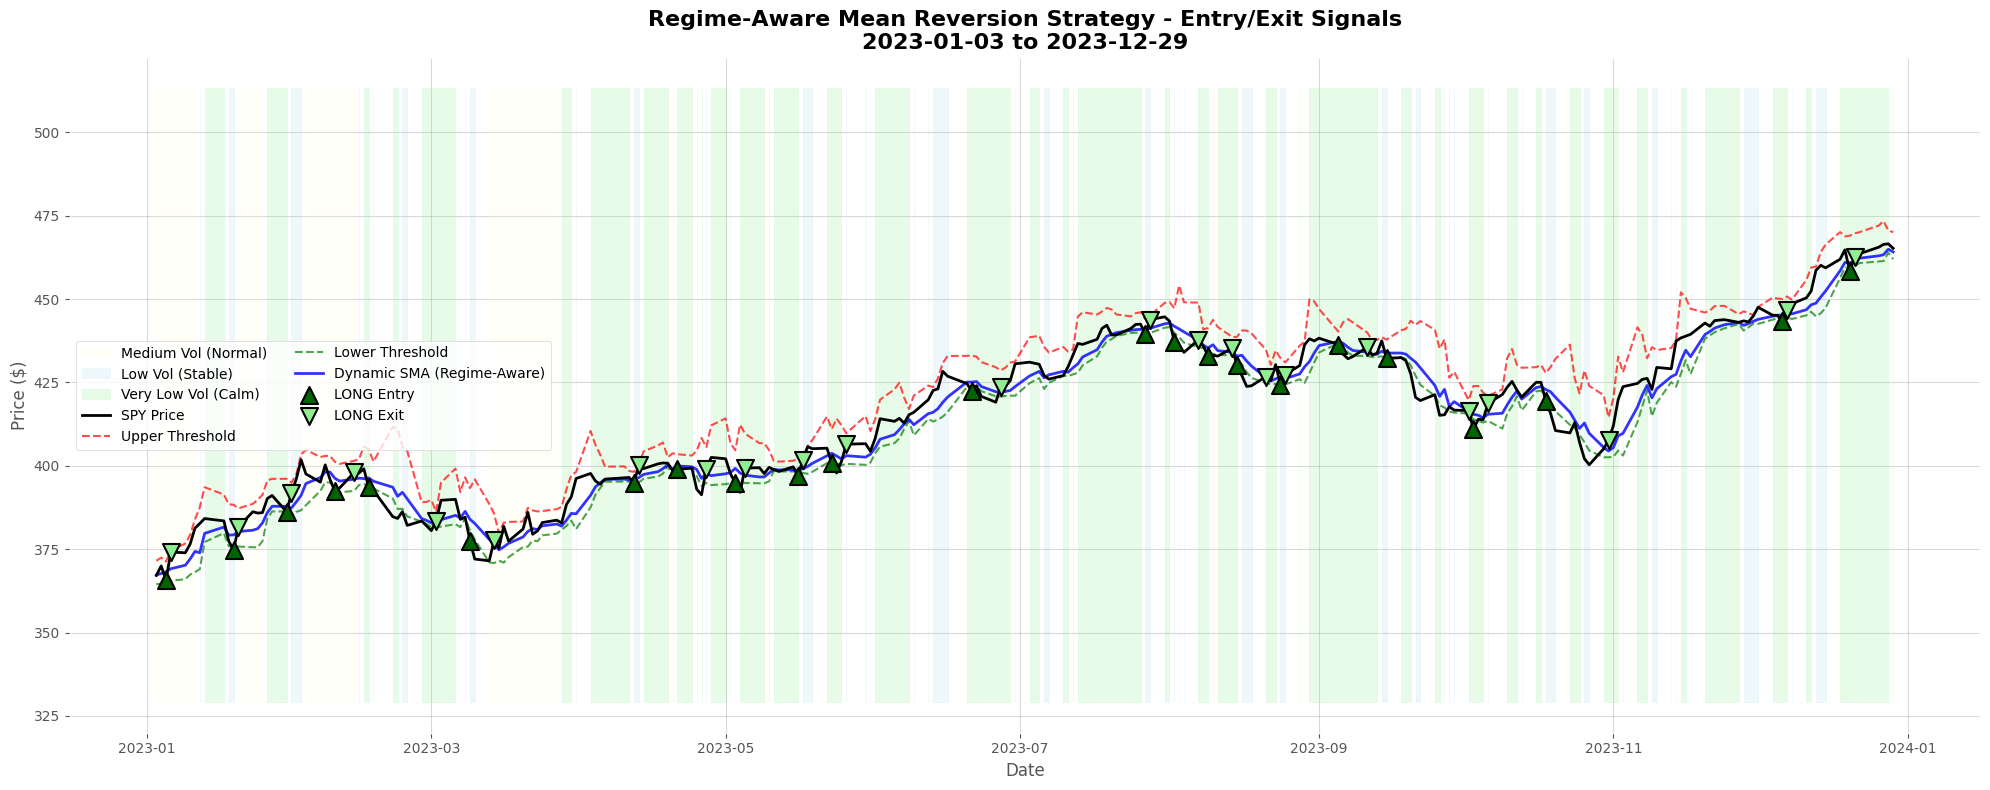


SIGNAL SUMMARY
Long Entries:  23
Long Exits:    23
Short Entries: 0
Short Exits:   0
Total Signals: 46

YEAR 2024
Trading days: 252
Date range: 2024-01-02 to 2024-12-31


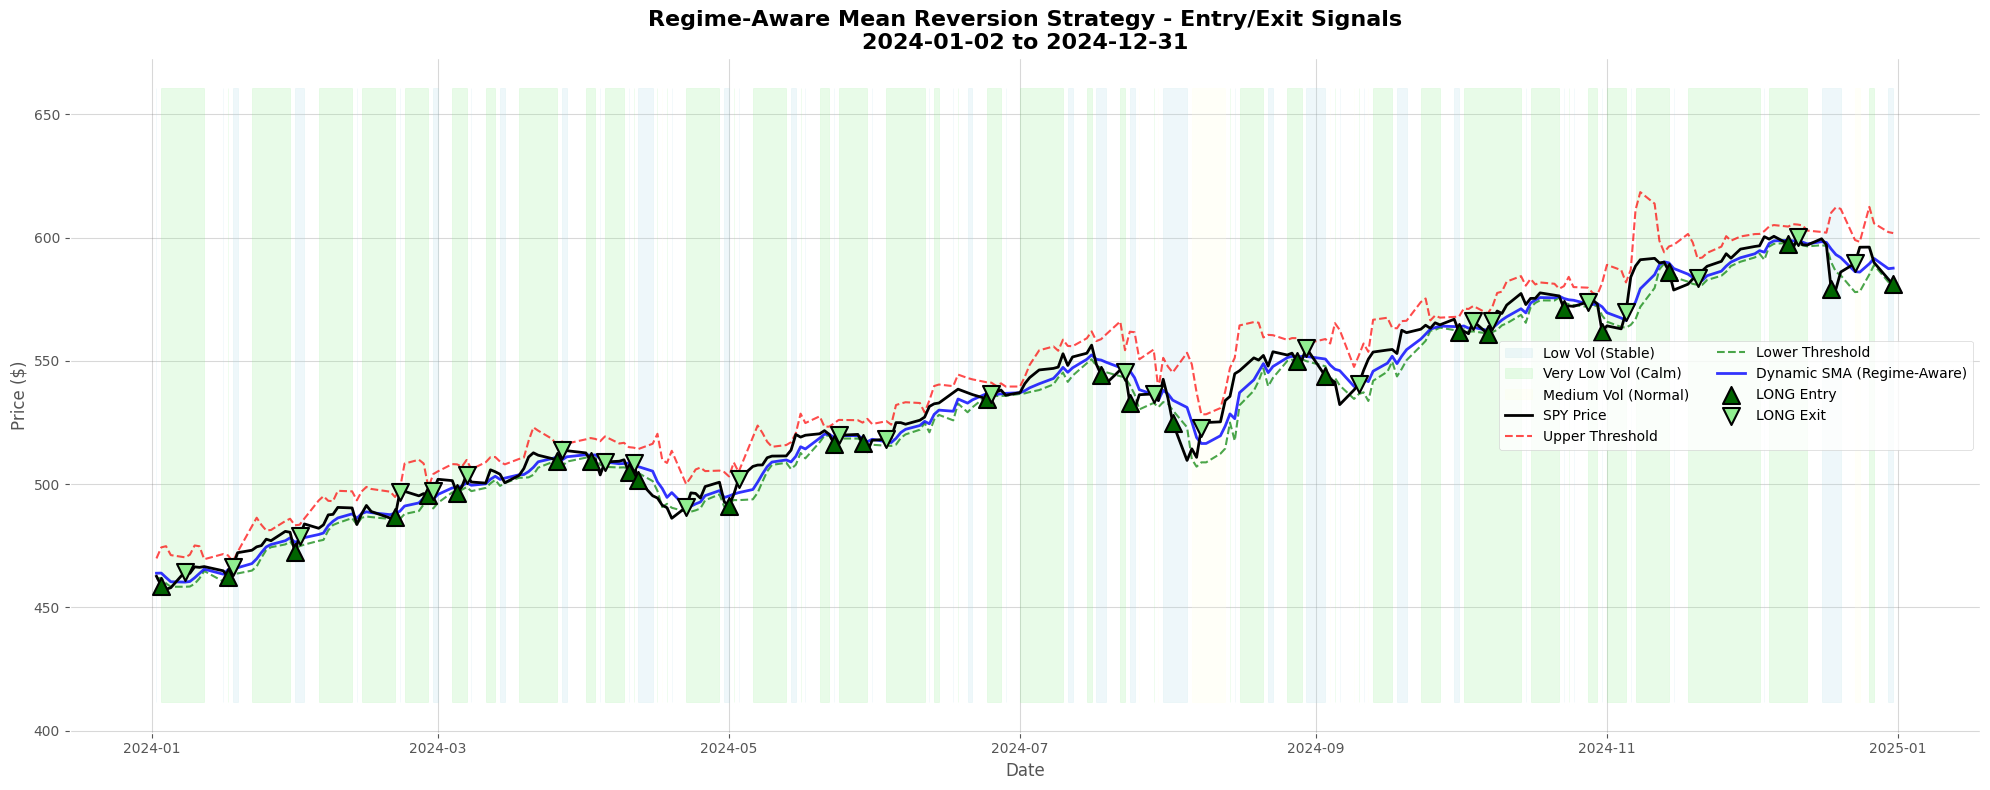


SIGNAL SUMMARY
Long Entries:  27
Long Exits:    26
Short Entries: 0
Short Exits:   0
Total Signals: 53

YEAR 2025
Trading days: 217
Date range: 2025-01-02 to 2025-11-12


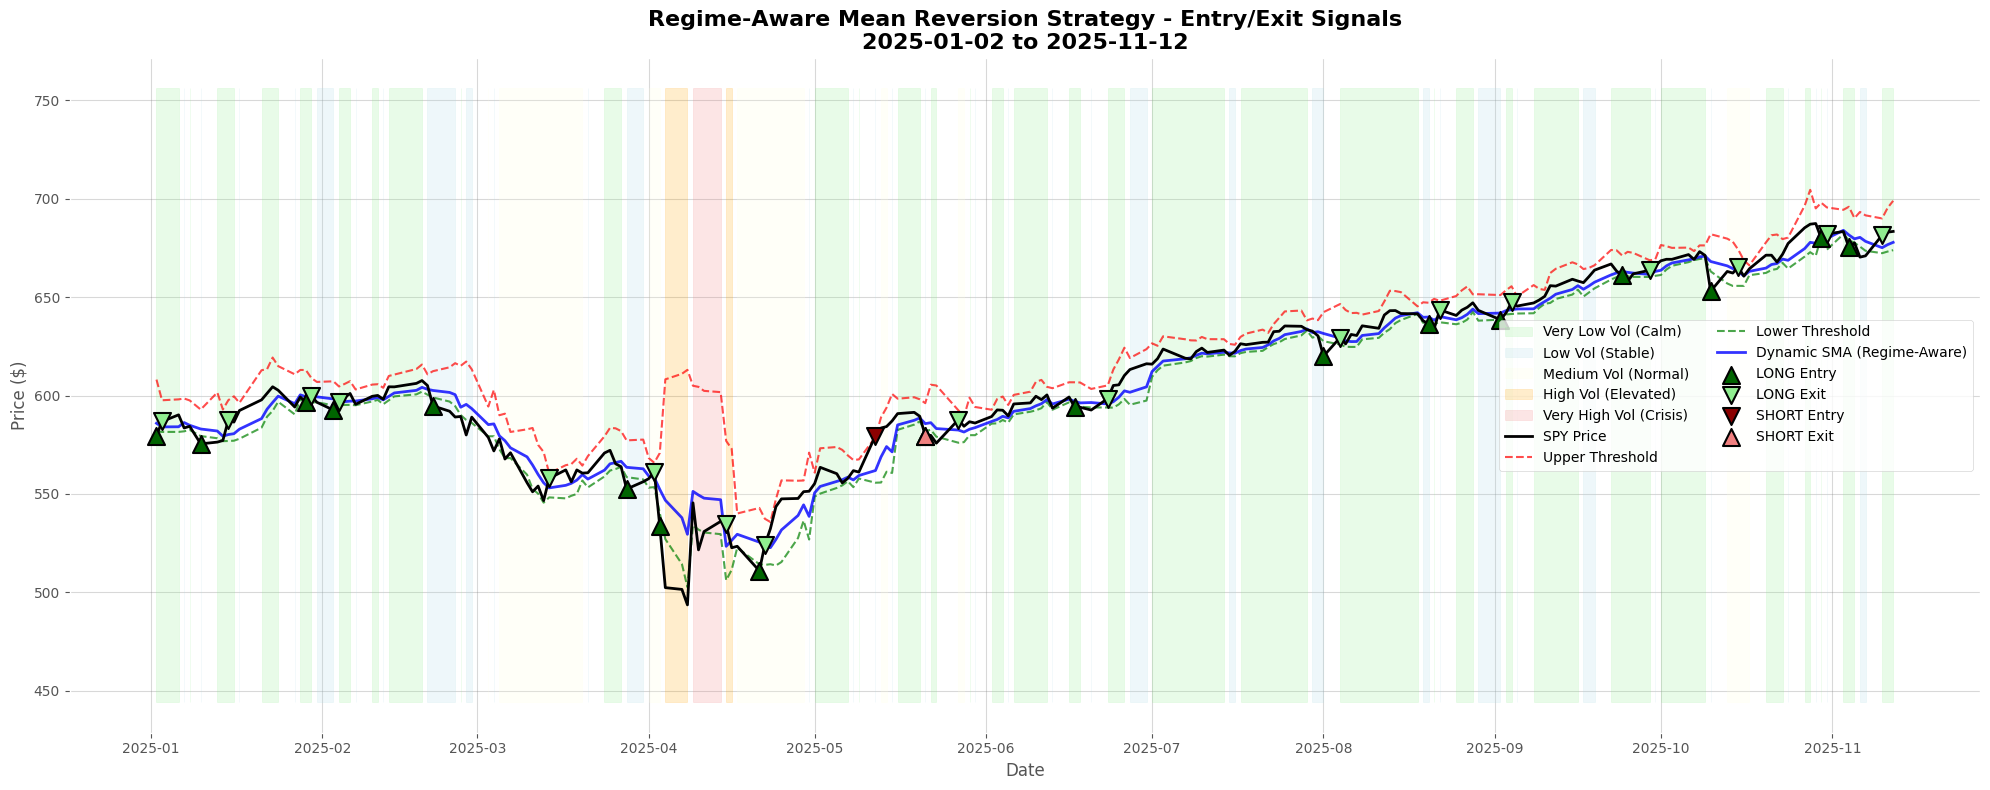


SIGNAL SUMMARY
Long Entries:  17
Long Exits:    17
Short Entries: 1
Short Exits:   1
Total Signals: 36

COMPLETED: All yearly visualizations generated


In [23]:
from mean_reversion_codebase import *
spy, spy_train, spy_test = mr_get_spy_raw()
spy_train_features, spy_test_features = mr_atr_volatility_kmeans_clustering(spy)
mean_reversion_A_test_unified_results = backtest_mean_reversion_sma_bb_strategy(spy_train_features, spy_test_features)
viz_mr_sma_bb_viz_regime_aware_backtest_signals(mean_reversion_A_test_unified_results)
mean_reversion_A_metrics = mr_global_compute_performance_metrics(mean_reversion_A_test_unified_results, initial_cash=100000, strategy='Mean_Reversion_A (SMA, Std, BB)')
combined_results.append(mean_reversion_A_metrics)


## <a id = "part1_2"></a> 1.2 Mean Reversion B - Dynamic RSI + Regime ATR & Volatility Clustering [back to table of contents](#top)


CALCULATING RSI FOR TRAIN AND TEST DATA
Train RSI - Mean: 55.55, Std: 11.51
Test RSI - Mean: 55.74, Std: 11.49


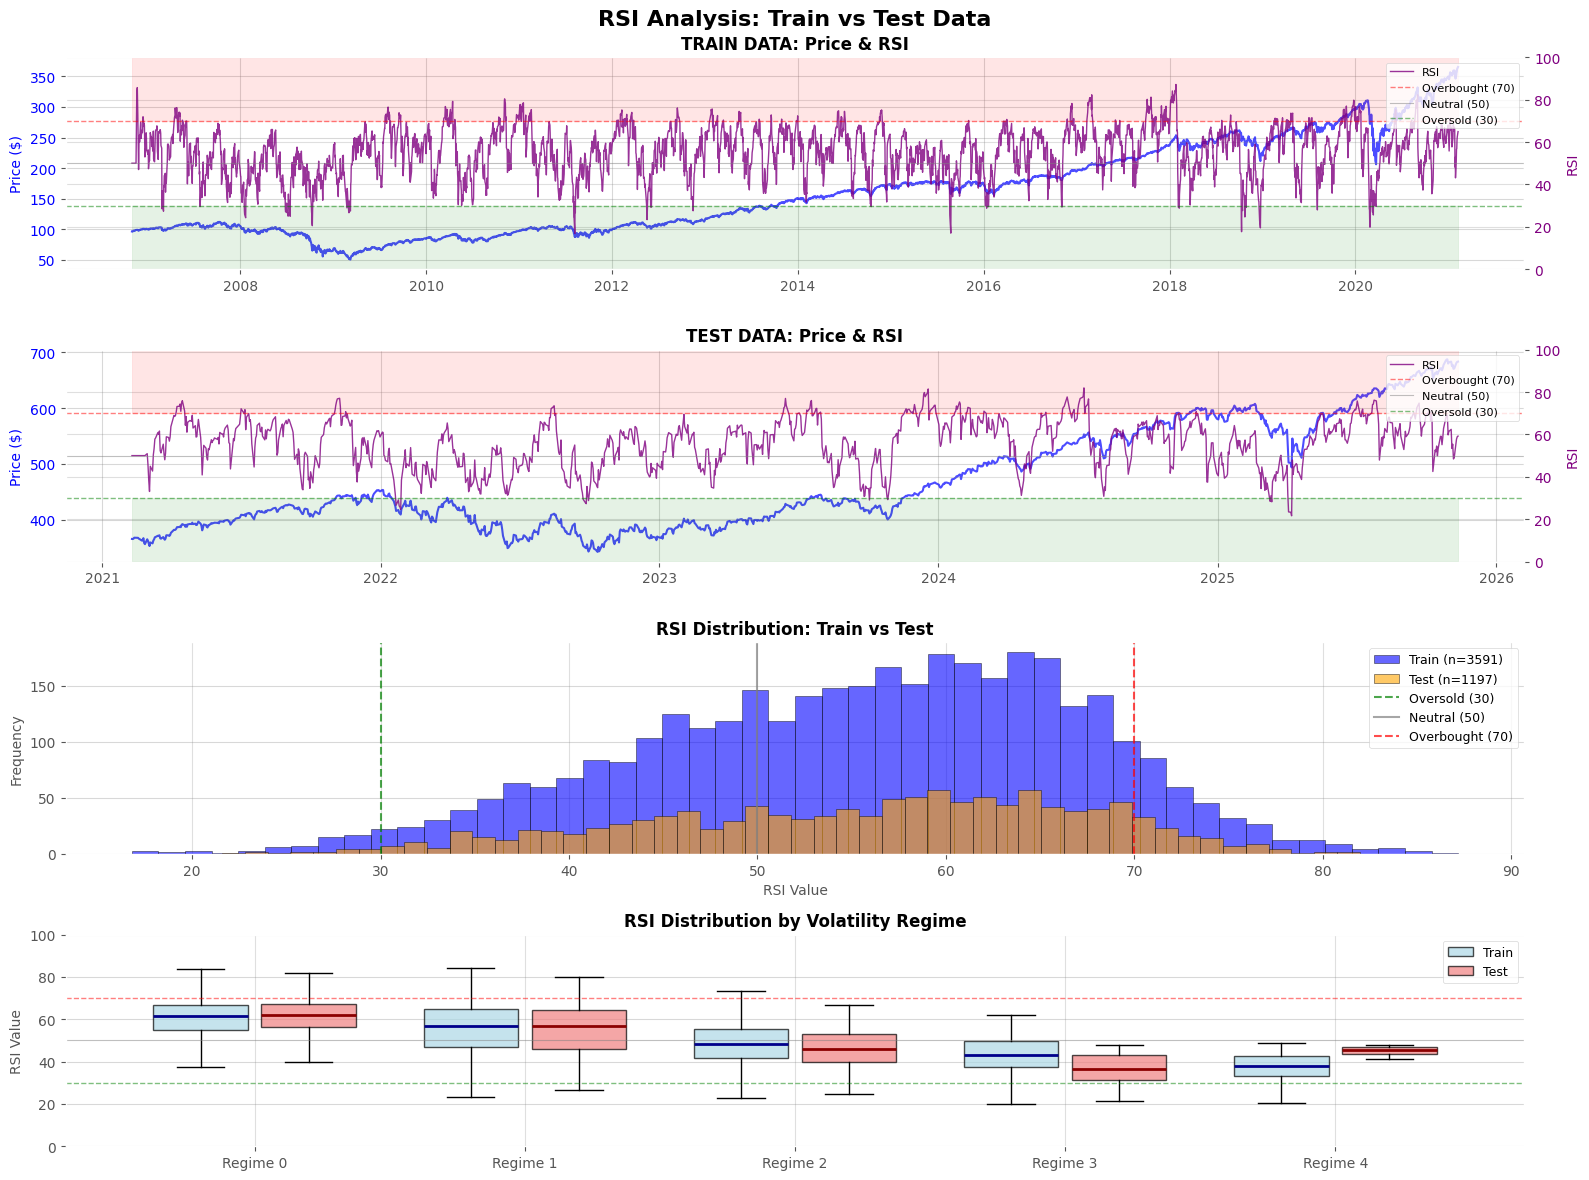


RSI STATISTICS

TRAIN DATA:
  Oversold (<30): 65 days (1.8%)
  Neutral (30-70): 3209 days (89.4%)
  Overbought (>70): 317 days (8.8%)

TEST DATA:
  Oversold (<30): 16 days (1.3%)
  Neutral (30-70): 1073 days (89.6%)
  Overbought (>70): 108 days (9.0%)

LOADING RSI REGIME PARAMETERS FROM CSV FILES (FROM TRAINING DATA)
✅ Loaded Very Low Vol (Calm):
   RSI_Period=7, RSI_Oversold=35, RSI_Overbought=70
✅ Loaded Low Vol (Stable):
   RSI_Period=17, RSI_Oversold=33, RSI_Overbought=78
✅ Loaded Medium Vol (Normal):
   RSI_Period=10, RSI_Oversold=35, RSI_Overbought=68
✅ Loaded High Vol (Elevated):
   RSI_Period=13, RSI_Oversold=32, RSI_Overbought=68
✅ Loaded Very High Vol (Crisis):
   RSI_Period=33, RSI_Oversold=35, RSI_Overbought=85

✅ Loaded parameters for 5 regimes from CSV

UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA

Training Data Period:
  Start Date: 2006-11-01
  End Date:   2021-02-08
  Total Days: 3591

Testing strategy on FULL training data with regime transitions...

Regime Paramete

Metric   Train    Test
0  Total Return (%)   52.71   33.14
1          CAGR (%)    3.01    6.20
2      Sharpe Ratio    0.30    0.62
3  Max Drawdown (%)  -25.08  -10.70
4      Total Trades     126      47


💡 INTERPRETATION:
   - Similar Sharpe ratios → Good generalization, no overfitting
   - Test Sharpe much lower → May be overfitted to train data
   - Test Sharpe higher → Got lucky with test period or train was more volatile

GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...


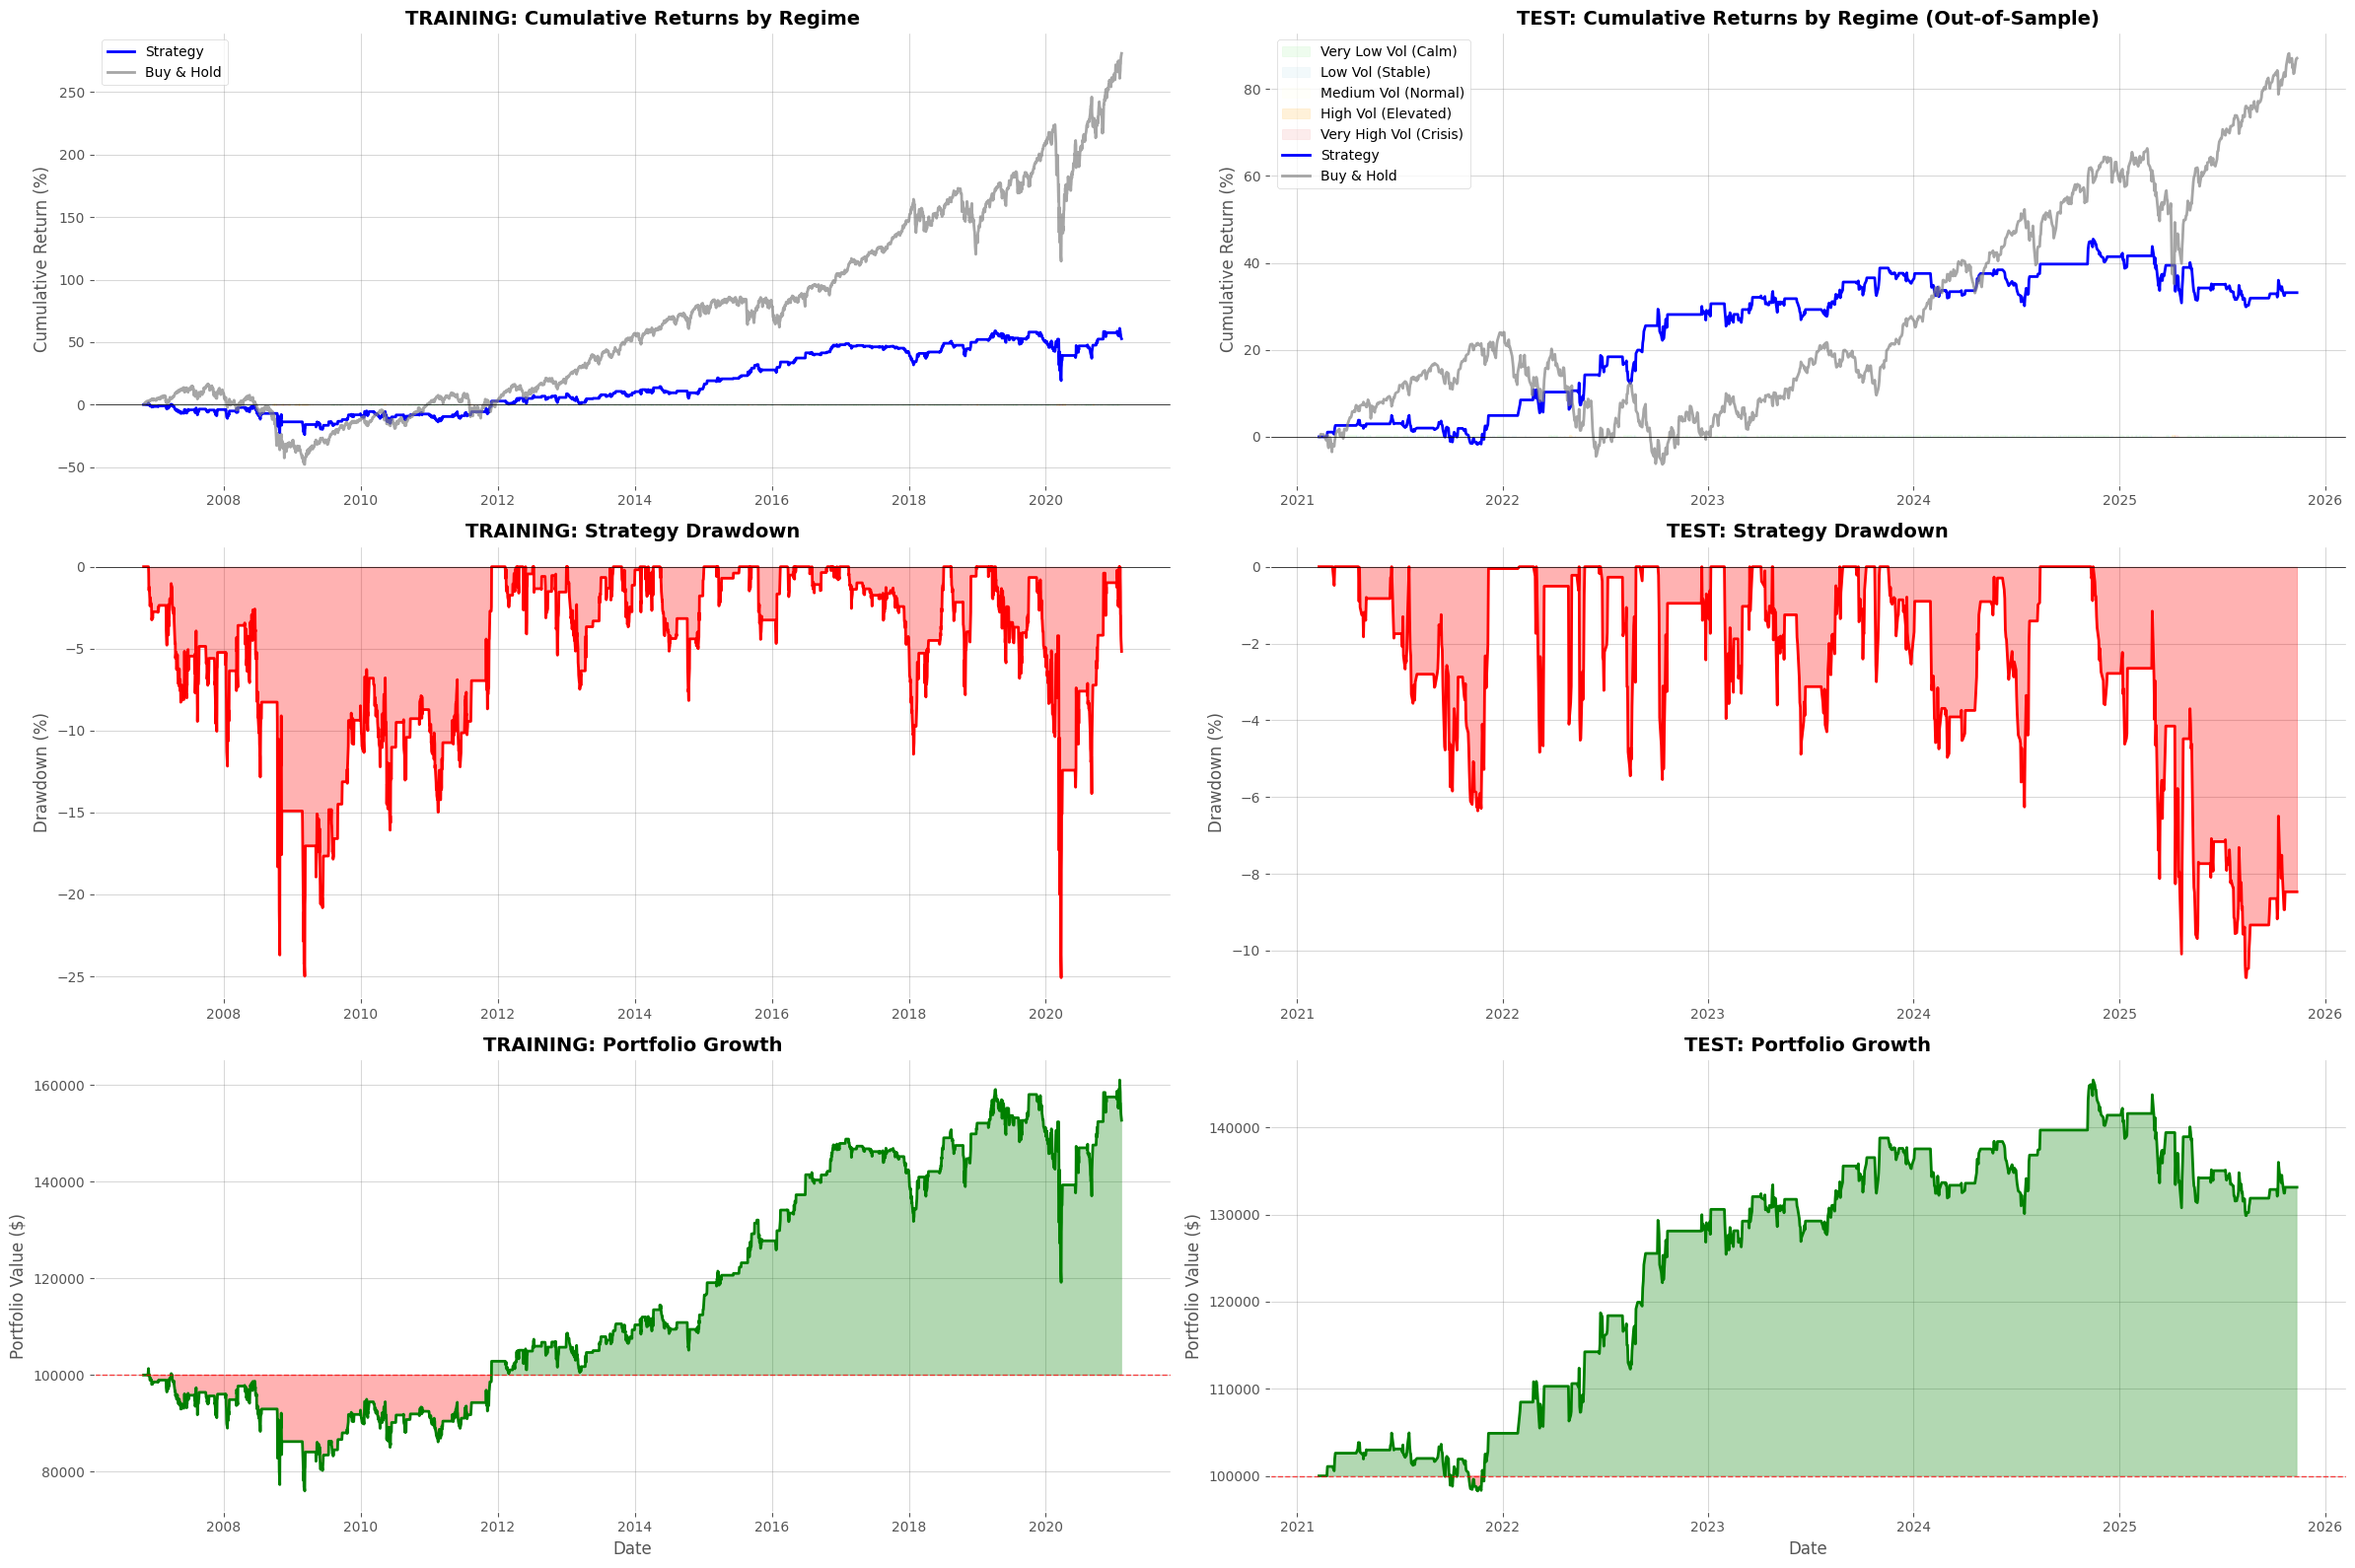


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                            52.71              33.14             280.95              87.04
Max Drawdown (%)                           -25.08             -10.70             -55.19             -24.50
Final Portfolio ($)            $       152,713.56 $       133,141.10 $       380,947.35 $       187,040.10


In [24]:
## Buy and Hold
# from mean_reversion_codebase import *
# spy, spy_train, spy_test = mr_get_spy_raw()
# spy_train_features, spy_test_features = mr_atr_volatility_kmeans_clustering(spy)
spy_train_features, spy_test_features, rig_fig = mr_visualize_rsi_analysis(spy_train_features, spy_test_features)
mean_reversion_B_test_unified_results = backtest_mean_reversion_rsi_strategy(spy_train_features, spy_test_features)
mean_reversion_B_metrics = mr_global_compute_performance_metrics(mean_reversion_B_test_unified_results, initial_cash=100000, strategy='Mean_Reversion_B (RSI)')
combined_results.append(mean_reversion_B_metrics)

## <a id = "part1_3"></a> 1.3 Mean Reversion C - Dynamic SMA Percentage Distance, Candle Counts + Regime ATR & Volatility Clustering [back to table of contents](#top)

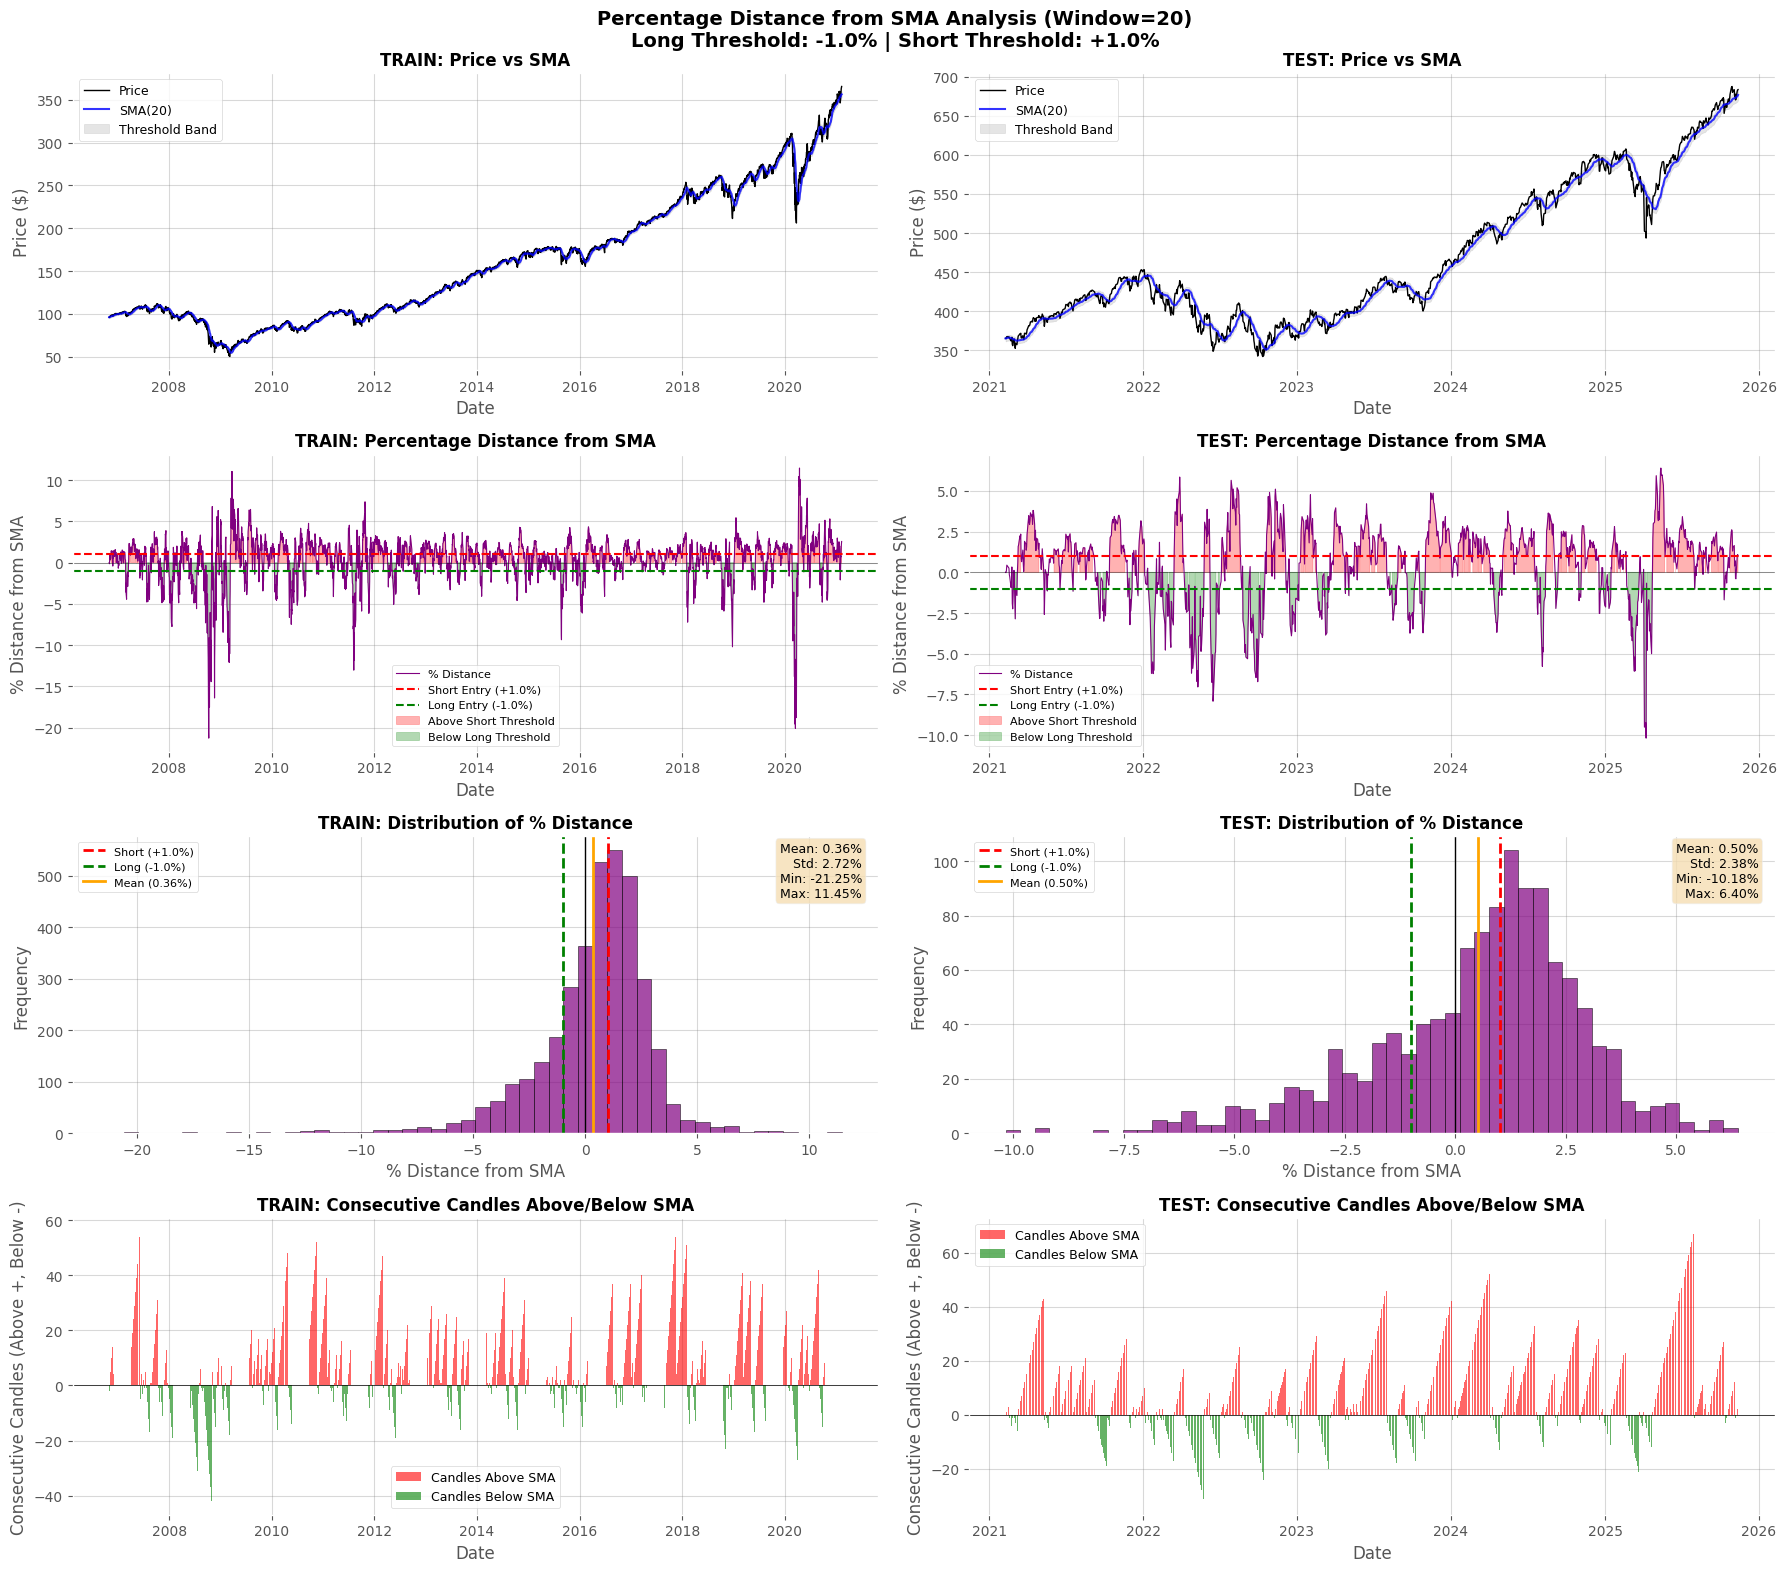


PERCENTAGE DISTANCE SUMMARY STATISTICS

Metric                                        TRAIN                 TEST
----------------------------------------------------------------------
Mean % Distance                               0.36%                0.50%
Std Dev % Distance                            2.72%                2.38%
Min % Distance                              -21.25%              -10.18%
Max % Distance                               11.45%                6.40%
Days Above Short Threshold                     1645                  593
Days Below Long Threshold                       750                  273
Max Consecutive Above SMA                        56                   68
Max Consecutive Below SMA                        42                   32
LOADING SMA PCT DISTANCE CANDLE + REGIME PARAMETERS FROM CSV FILES (FROM TRAINING DATA)
✅ Loaded Very Low Vol (Calm): Window=5, Pct_Long=0.4, Pct_Short=1.2, Min_Candles=1
✅ Loaded Low Vol (Stable): Window=5, Pct_Long=0.5, Pct_Short

Metric   Train    Test
0  Total Return (%)  229.08   94.36
1          CAGR (%)    8.70   15.00
2      Sharpe Ratio    0.57    1.18
3  Max Drawdown (%)  -28.44  -10.10
4      Total Trades     496     177


💡 INTERPRETATION:
   - Similar Sharpe ratios → Good generalization, no overfitting
   - Test Sharpe much lower → May be overfitted to train data
   - Test Sharpe higher → Got lucky with test period or train was more volatile

GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...


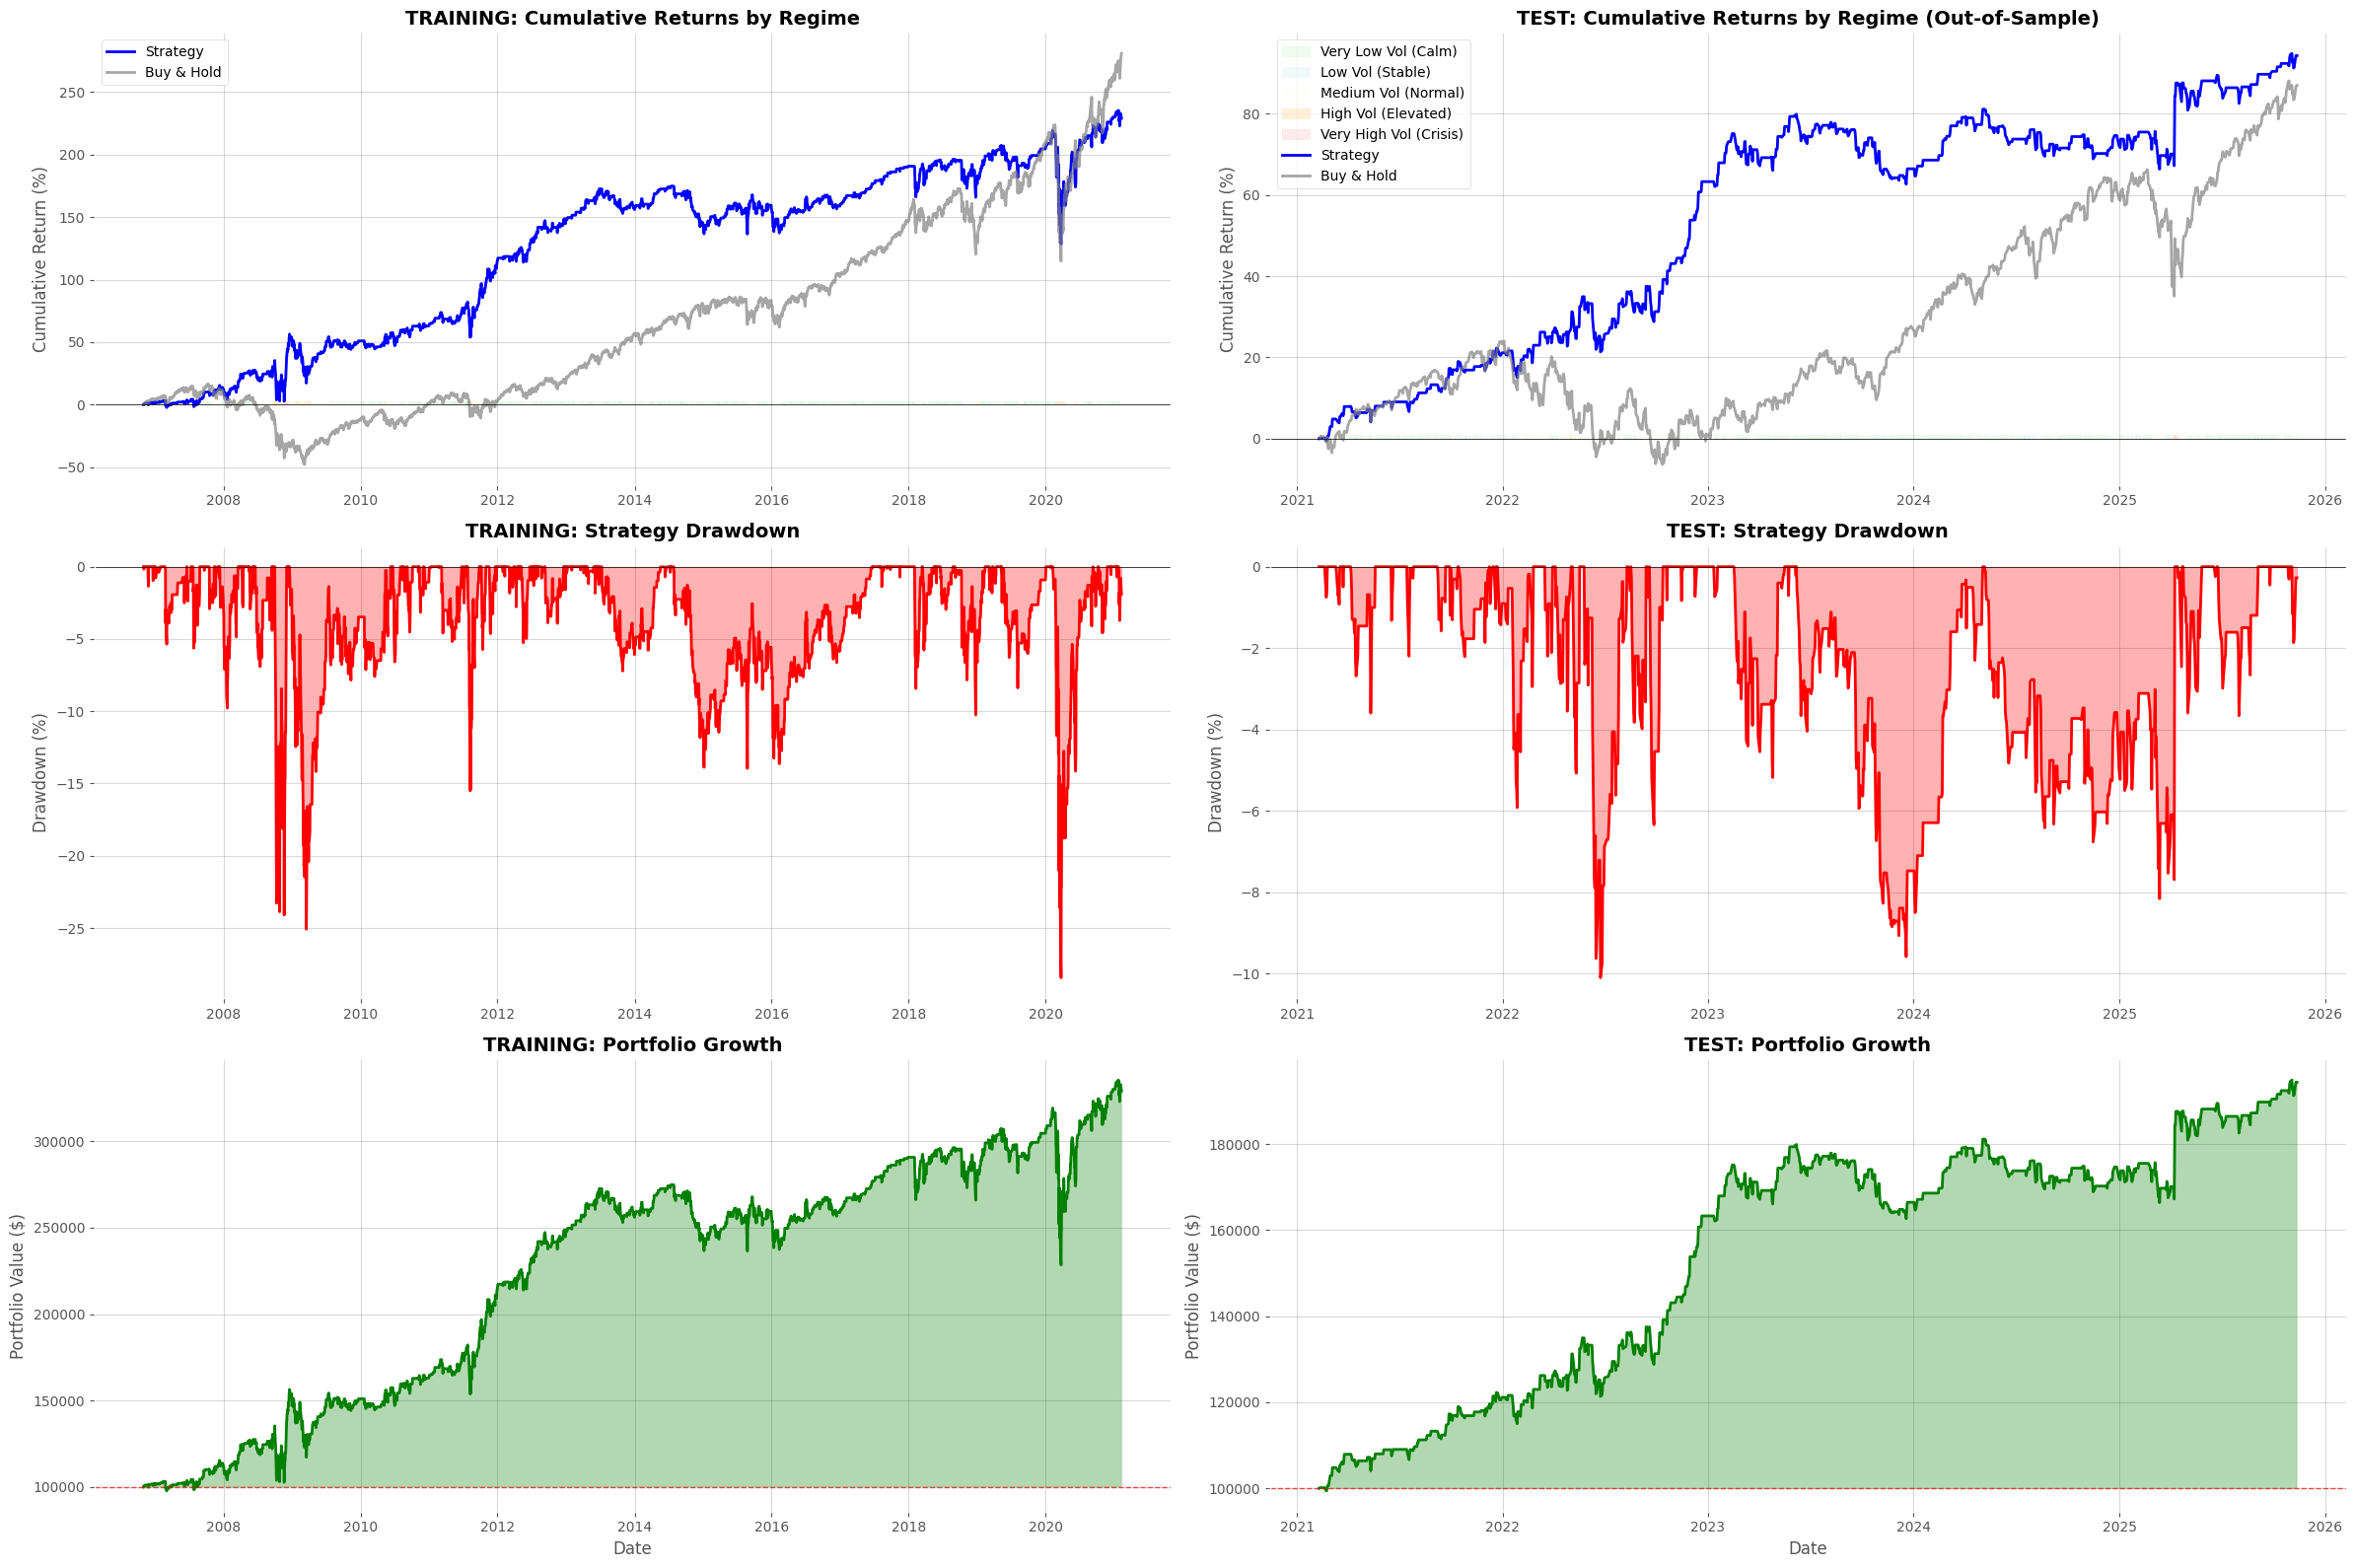


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                           229.08              94.36             280.95              87.04
Max Drawdown (%)                           -28.44             -10.10             -55.19             -24.50
Final Portfolio ($)            $       329,083.22 $       194,358.82 $       380,947.35 $       187,040.10

TEST DATA: Entry/Exit Signals with Regime Background (Year by Year)

Test data spans 5 years: 2021 - 2025
Generating 5 separate visualizations...


YEAR 2021
Trading days: 227
Date range: 2021-02-09 to 2021-12-31


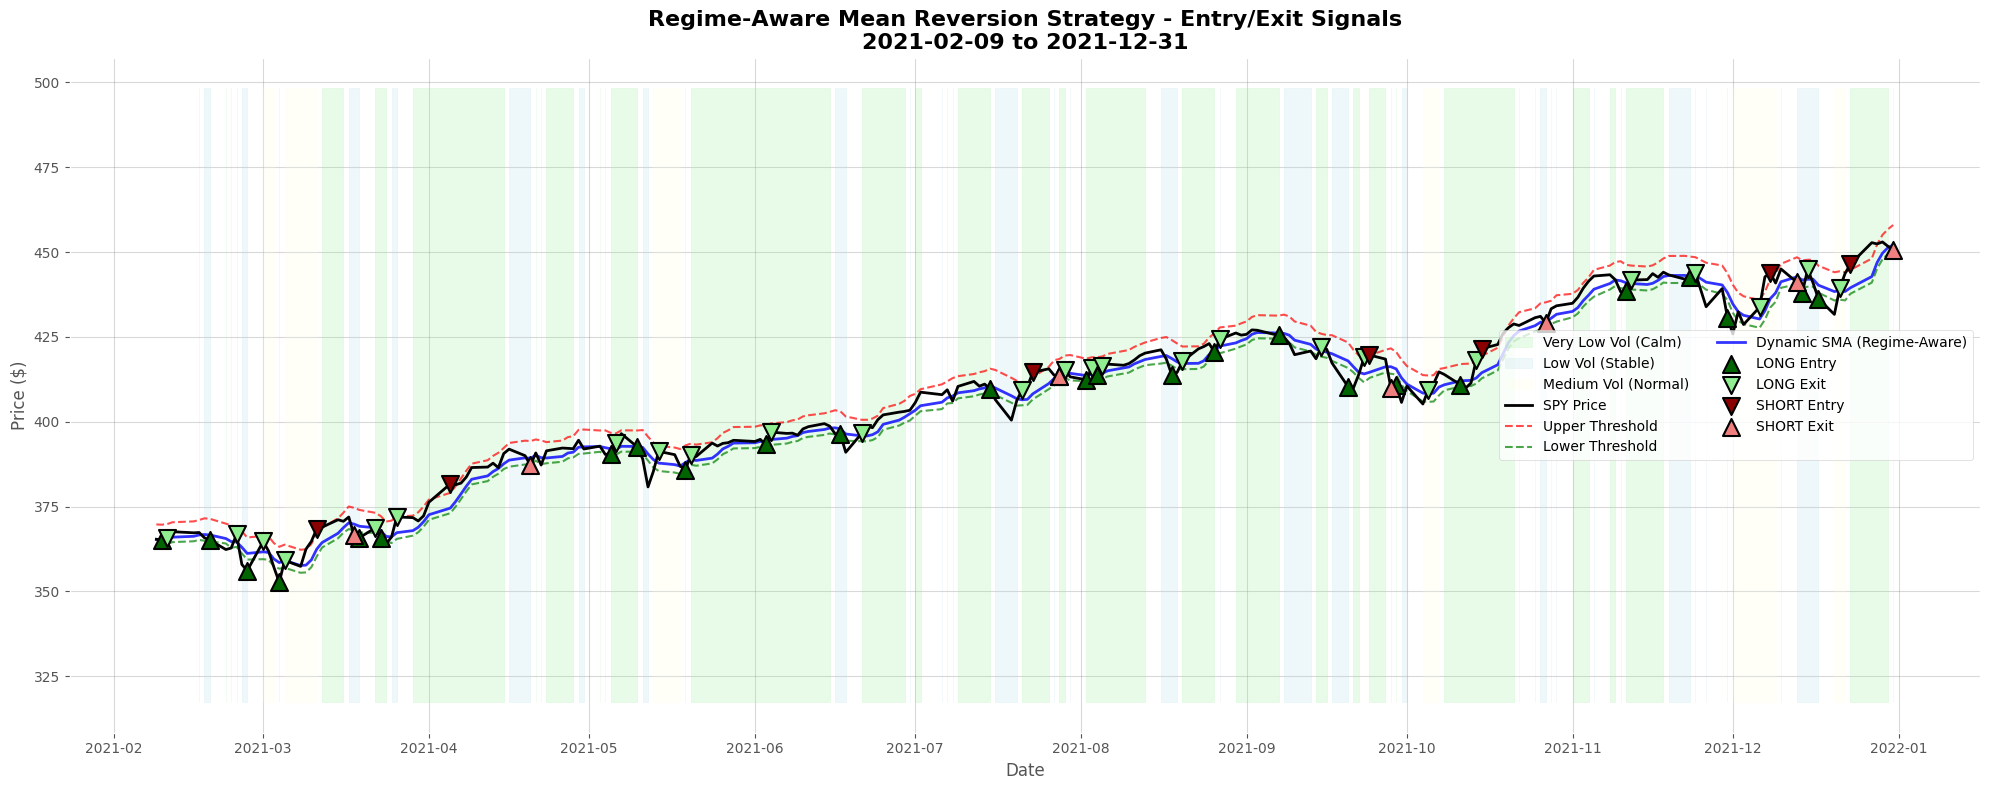


SIGNAL SUMMARY
Long Entries:  26
Long Exits:    26
Short Entries: 7
Short Exits:   7
Total Signals: 66

YEAR 2022
Trading days: 251
Date range: 2022-01-03 to 2022-12-30


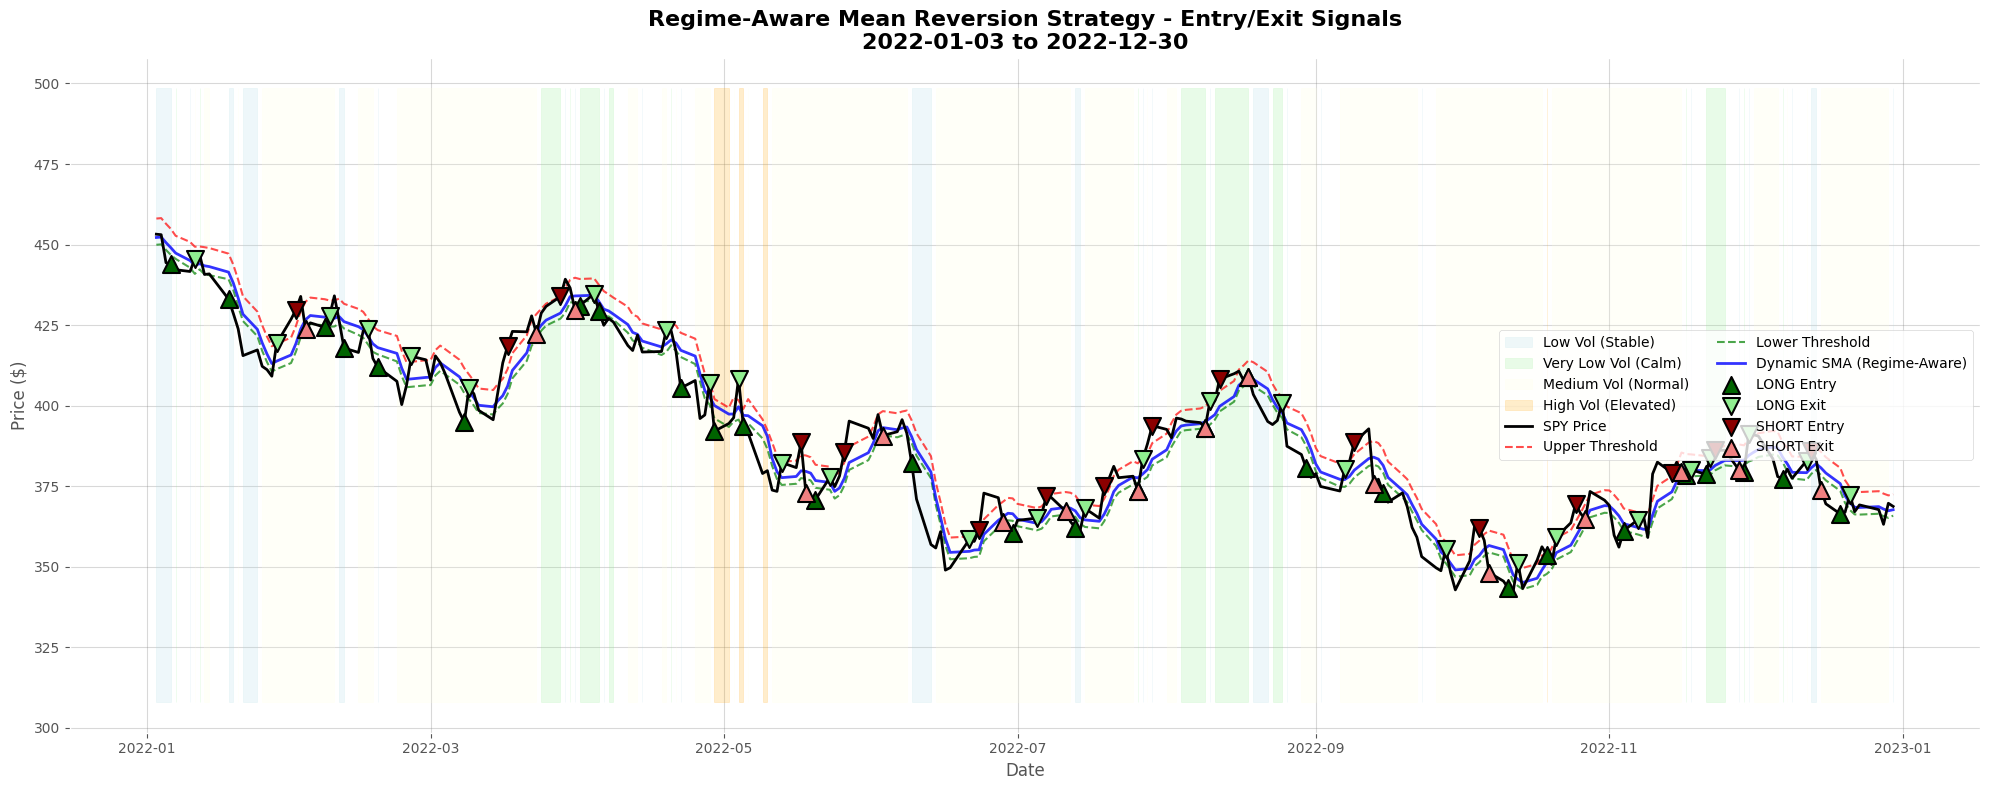


SIGNAL SUMMARY
Long Entries:  28
Long Exits:    28
Short Entries: 16
Short Exits:   16
Total Signals: 88

YEAR 2023
Trading days: 250
Date range: 2023-01-03 to 2023-12-29


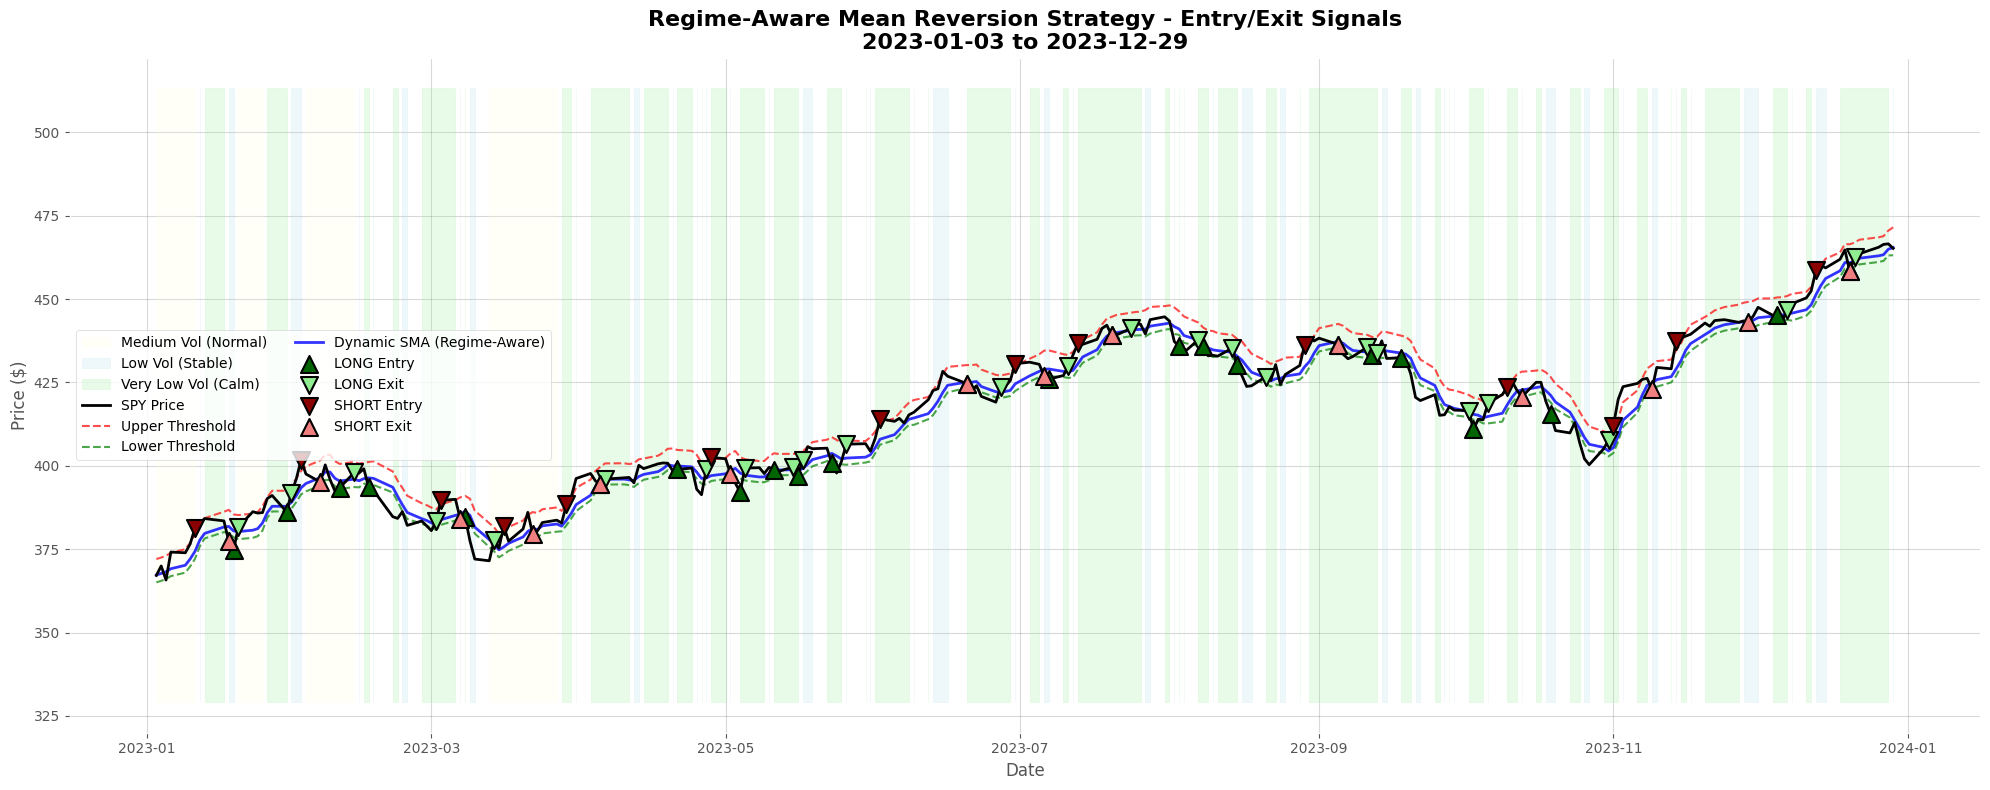


SIGNAL SUMMARY
Long Entries:  24
Long Exits:    24
Short Entries: 14
Short Exits:   14
Total Signals: 76

YEAR 2024
Trading days: 252
Date range: 2024-01-02 to 2024-12-31


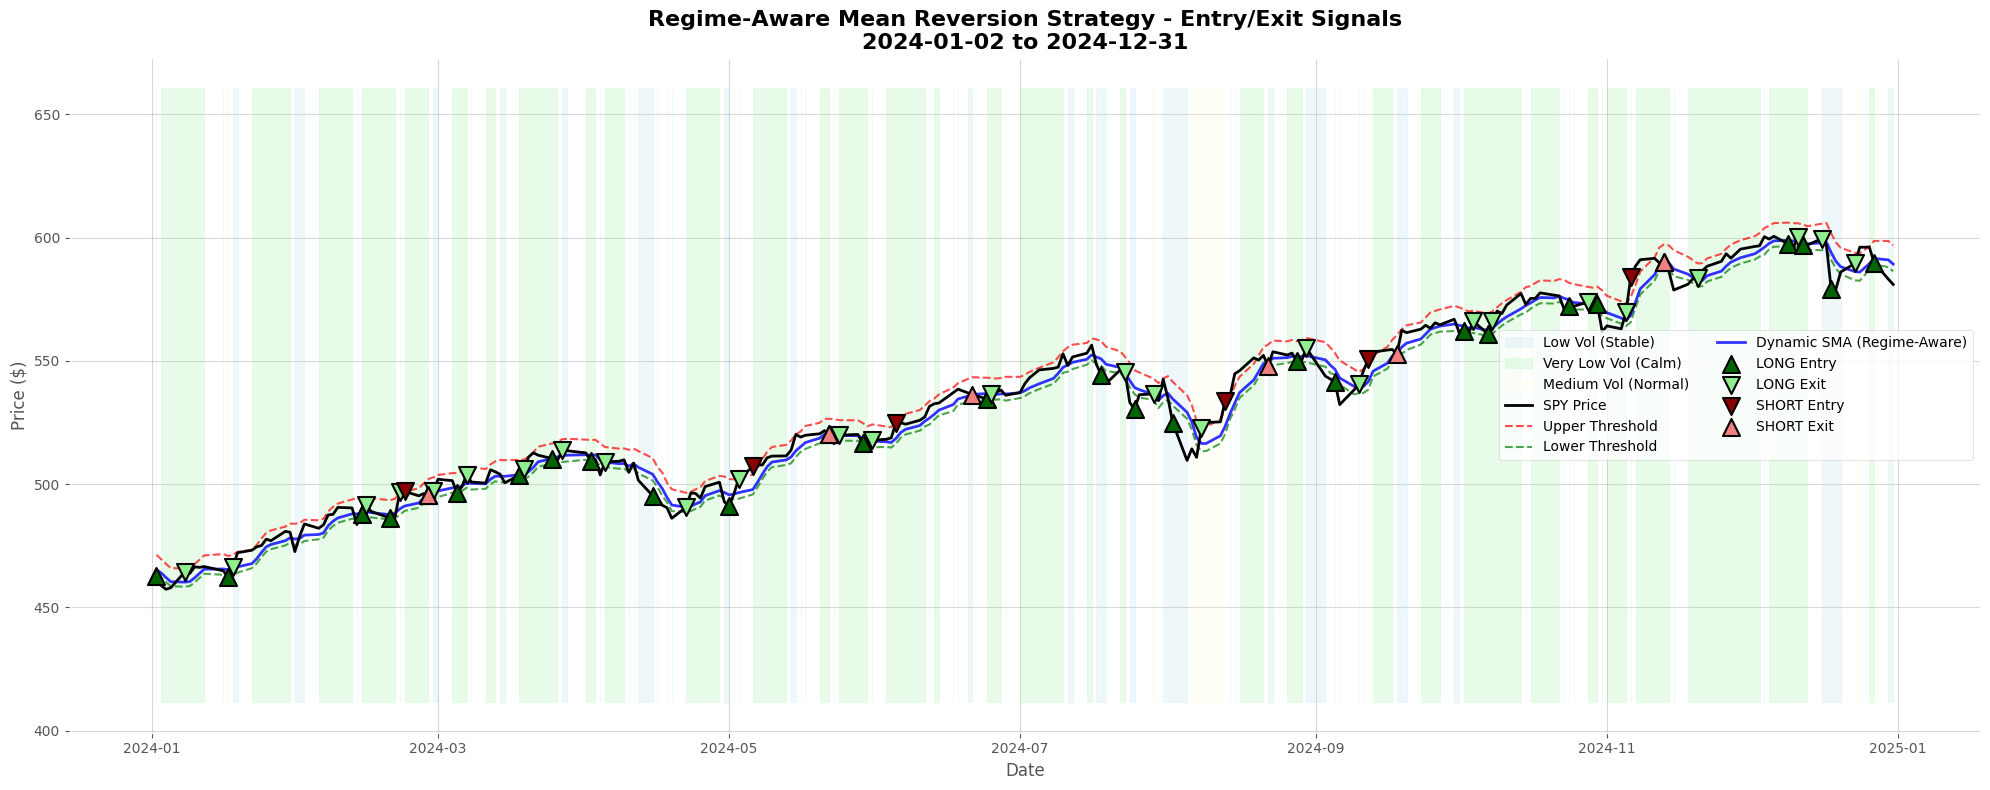


SIGNAL SUMMARY
Long Entries:  28
Long Exits:    27
Short Entries: 6
Short Exits:   6
Total Signals: 67

YEAR 2025
Trading days: 217
Date range: 2025-01-02 to 2025-11-12


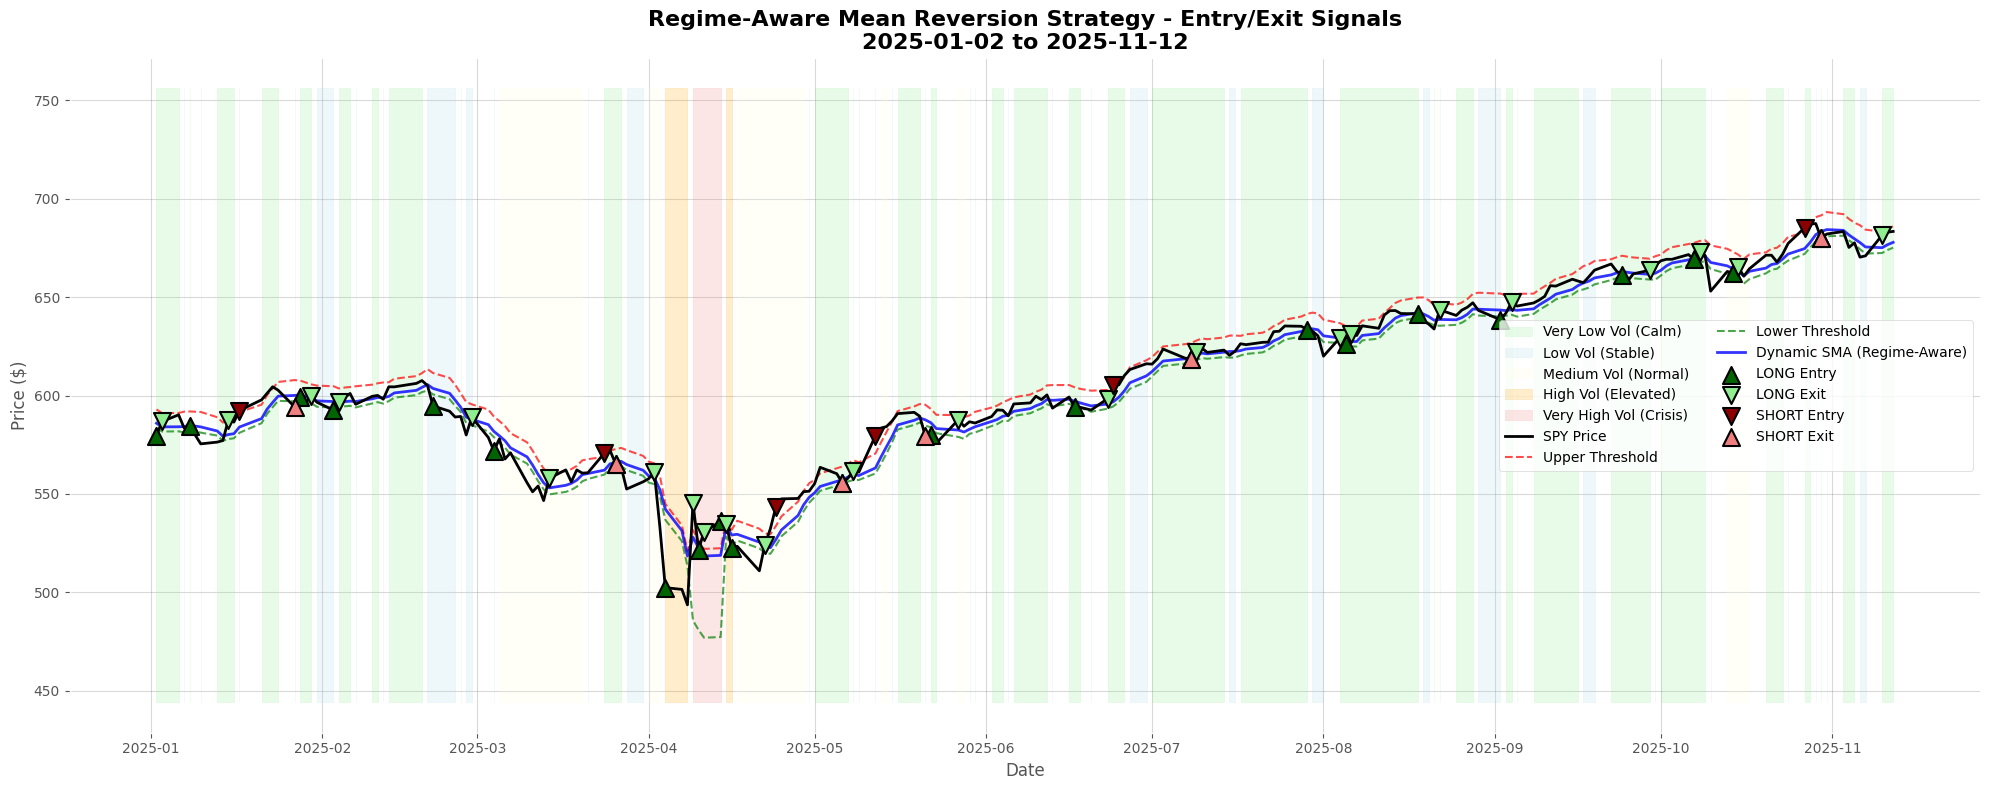


SIGNAL SUMMARY
Long Entries:  23
Long Exits:    23
Short Entries: 6
Short Exits:   6
Total Signals: 58

COMPLETED: All yearly visualizations generated


In [25]:
# from mean_reversion_codebase import *
# spy, spy_train, spy_test = mr_get_spy_raw()
# spy_train_features, spy_test_features = mr_atr_volatility_kmeans_clustering(spy)
train_calc, test_calc = mr_sma_pct_candle_viz_pct_distance_analysis(
      spy_train_features,
      spy_test_features,
      window=20,
      pct_threshold_long=1.0,
      pct_threshold_short=1.0
)

mean_reversion_C_test_unified_results = backtest_mean_reversion_sma_pct_candle_strategy(spy_train_features, spy_test_features)
viz_mr_sma_pct_candle_regime_aware_backtest_signals(mean_reversion_C_test_unified_results)

mean_reversion_C_metrics = mr_global_compute_performance_metrics(mean_reversion_C_test_unified_results, initial_cash=100000, strategy='Mean_Reversion_C (SMA Pct Dist + Candle Counts)')
combined_results.append(mean_reversion_C_metrics)



## <a id = "part14"></a> 1.4 ML-Enhanced Adaptive SMA [back to table of contents](#top)

This strategy uses SMA momentum crossover, and we hyperparameterized the long and short windows, and also using the ML signal as a confirmation for momentum

In [26]:
# original, overfitting suspected, removing it for now
# short_windows = np.arange(1,301)
# long_windows  = np.arange(1,301)
# momentum_tasks = [
#     (s, l)
#     for s in short_windows
#     for l in long_windows
#     if l > s
# ]

short_windows = range(3, 10)
ratio_values = np.arange(1.5,6.5,0.5)

momentum_tasks = [
    (s, int(s * r))
    for s in short_windows
    for r in ratio_values
]

len(momentum_tasks)

70

In [27]:
adaptive_sma =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/sma_tuned_with_signal.csv",
        signal_check=True
    )
)

adaptive_sma

Loaded cached Momentum results from: data/sma_tuned_with_signal.csv


short_window  long_window  regime  cumulative_return    sharpe
0              7           10     NaN           4.275484  0.629640
1              3            4     NaN           4.252271  0.557656
2              6           12     NaN           4.247251  0.630437
3              9           13     NaN           4.117687  0.625098
4              4           16     NaN           4.101432  0.615816
5              3           16     NaN           4.089332  0.619439
6              3           18     NaN           3.969703  0.603514
7              5           27     NaN           3.943816  0.637139
8              5           30     NaN           3.904248  0.629959
9              8           12     NaN           3.874649  0.589195
10             4           14     NaN           3.872967  0.588600
11             5           15     NaN           3.848612  0.587441
12             3           15     NaN           3.801028  0.585448
13             5           12     NaN           3.779032  0.574699
14             4           12     NaN           3.771404  0.574490
15             5            7     NaN           3.761257  0.549060
16             6           36     NaN           3.750012  0.618919
17             6           30     NaN           3.745442  0.617807
18             5           17     NaN           3.704130  0.580456
19             9           31     NaN           3.699356  0.622445
20             9           40     NaN           3.689714  0.633181
21             6           33     NaN           3.680137  0.614898
22             9           27     NaN           3.658546  0.601867
23             4           18     NaN           3.654524  0.570079
24             8           36     NaN           3.635099  0.611333
25             6           27     NaN           3.618055  0.590530
26             7           28     NaN           3.605879  0.597090
27             9           22     NaN           3.587904  0.562398
28             5           10     NaN           3.575082  0.540610
29             7           14     NaN           3.547033  0.552572
30             6            9     NaN           3.526987  0.533374
31             8           24     NaN           3.518645  0.572013
32             8           28     NaN           3.512472  0.592343
33             7           42     NaN           3.511970  0.611884
34             8           16     NaN           3.500058  0.538508
35             9           36     NaN           3.468663  0.594572
36             8           32     NaN           3.467465  0.593484
37             3           10     NaN           3.463806  0.530736
38             7           24     NaN           3.414188  0.556652
39             8           44     NaN           3.412340  0.599059
40             9           45     NaN           3.412223  0.601217
41             7           38     NaN           3.406890  0.581947
42             6           15     NaN           3.406888  0.533302
43             3           13     NaN           3.405732  0.523938
44             3            6     NaN           3.405247  0.517383
45             8           20     NaN           3.390967  0.550018
46             7           35     NaN           3.388681  0.575526
47             4            6     NaN           3.364769  0.495897
48             8           40     NaN           3.347601  0.588069
49             5           25     NaN           3.340680  0.549058
50             9           49     NaN           3.300766  0.587703
51             7           31     NaN           3.284016  0.564977
52             4            8     NaN           3.270301  0.487219
53             6           18     NaN           3.265642  0.522382
54             7           17     NaN           3.258766  0.521475
55             3           12     NaN           3.234532  0.502396
56             3            9     NaN           3.208452  0.493152
57             5           22     NaN           3.188933  0.521547
58             7           21     NaN           3.1

In [28]:
best_momentum = adaptive_sma.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(7.0, 10.0)

In [29]:
best_sma =\
(
    SMA(
        df=df_test,
        windows=[int(best_short),int(best_long)]
    )
)
best_sma_portfolio =\
(
    compute_portfolio(
        best_sma,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [30]:
best_sma_metrics =\
(
    compute_performance_metrics(
        best_sma_portfolio['strategy_returns'],
        initial_capital=starting_capital,
        strategy='ML-Enhanced Adaptive SMA'
    )
)
best_sma_metrics

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
ML-Enhanced Adaptive SMA  0.136       0.106         0.123         1.256          2.023         1.105             183489.215              1.835

In [31]:
combined_results.append(best_sma_metrics)

## <a id = "part15"></a> 1.5 Adaptive Risk-Adjusted SMA [back to table of contents](#top)

This strategy adjusts position sizes based on volatility and uses ML signals as a filter, implementing risk management through dynamic position sizing.

In [32]:
# Adaptive Risk-Adjusted Strategy
adaptive_df = df_test.copy()

# Calculate volatility (20-day rolling standard deviation of returns)
adaptive_df['returns'] = adaptive_df['Close'].pct_change()
adaptive_df['volatility'] = adaptive_df['returns'].rolling(window=20).std()

# Calculate momentum signals using optimized windows
adaptive_df['sma_short'] = adaptive_df['Close'].rolling(window=int(best_short)).mean()
adaptive_df['sma_long'] = adaptive_df['Close'].rolling(window=int(best_long)).mean()
adaptive_df['momentum_signal'] = (adaptive_df['sma_short'] > adaptive_df['sma_long']).astype(int)

# Calculate ATR for volatility adjustment
high_low = adaptive_df['High'] - adaptive_df['Low']
high_close = np.abs(adaptive_df['High'] - adaptive_df['Close'].shift())
low_close = np.abs(adaptive_df['Low'] - adaptive_df['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
adaptive_df['atr'] = true_range.rolling(window=14).mean()

# Inverse volatility weighting: scale positions inversely with volatility
# Higher volatility = smaller position, lower volatility = larger position
mean_vol = adaptive_df['volatility'].mean()
adaptive_df['vol_scale'] = (mean_vol / adaptive_df['volatility']).clip(0.5, 1.5)  # Clip between 0.5x and 1.5x

# Combined signal: ML + Momentum + Volatility adjustment
adaptive_df['base_signal'] = (adaptive_df['ml_signal'] == 1) & (adaptive_df['momentum_signal'] == 1)
adaptive_df['positions'] = adaptive_df['base_signal'].astype(float) * adaptive_df['vol_scale']

# Fill NaN values
adaptive_df['positions'] = adaptive_df['positions'].fillna(0)

adaptive_df[['Close', 'volatility', 'vol_scale', 'positions']].tail(10)

Price            Close  volatility  vol_scale  positions
Date                                                    
2025-10-30  679.830017    0.009254   1.062153   1.062153
2025-10-31  682.059998    0.009268   1.060602   1.060602
2025-11-03  683.340027    0.009250   1.062587   1.062587
2025-11-04  675.239990    0.009636   1.020109   1.020109
2025-11-05  677.580017    0.009577   1.026343   1.026343
2025-11-06  670.309998    0.009874   0.995534   0.000000
2025-11-07  670.969971    0.007555   1.301091   0.000000
2025-11-10  681.440002    0.007580   1.296714   0.000000
2025-11-11  683.000000    0.007557   1.300698   0.000000
2025-11-12  683.380005    0.007529   1.305484   0.000000

In [33]:
# Compute portfolio performance with variable position sizing
adaptive_df["passive_returns"] = np.log(adaptive_df['Close'] / adaptive_df['Close'].shift(1))
adaptive_df['strategy_returns'] = adaptive_df['positions'].shift(1) * adaptive_df['passive_returns']
adaptive_df['cum_log_returns'] = adaptive_df['strategy_returns'].cumsum()
adaptive_df['cumulative_strategy_returns'] = np.exp(adaptive_df['cum_log_returns'])
adaptive_df['cumulative_passive_returns'] = np.exp(adaptive_df['passive_returns'].fillna(0).cumsum())

adaptive_df[['cumulative_strategy_returns', 'cumulative_passive_returns', 'positions']].tail(10)

Price       cumulative_strategy_returns  cumulative_passive_returns  positions
Date                                                                          
2025-10-30                     1.698862                    1.860684   1.062153
2025-10-31                     1.704782                    1.866788   1.060602
2025-11-03                     1.708175                    1.870291   1.062587
2025-11-04                     1.686668                    1.848121   1.020109
2025-11-05                     1.692631                    1.854526   1.026343
2025-11-06                     1.673994                    1.834628   0.000000
2025-11-07                     1.673994                    1.836434   0.000000
2025-11-10                     1.673994                    1.865091   0.000000
2025-11-11                     1.673994                    1.869360   0.000000
2025-11-12                     1.673994                    1.870400   0.000000

In [34]:
# Calculate performance metrics for adaptive strategy
adaptive_metrics = \
(
    compute_performance_metrics(
        log_returns=adaptive_df['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy='Adaptive Risk-Adjusted SMA'
    )
)

print(adaptive_metrics)

                             CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Adaptive Risk-Adjusted SMA  0.114       0.106         0.105         1.073           1.69         1.094             167399.436              1.674


In [35]:
# Plot adaptive strategy performance
(
    plot_cumulative_returns(
        df=adaptive_df.reset_index(),
        date_column='Date',
        strategy_column='cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )
)

In [36]:
# Add to combined results
combined_results.append(adaptive_metrics)

## <a id = "part16"></a> 1.6 Adaptive EMA [back to table of contents](#top)

In [37]:
short_windows = range(3, 30)
ratio_values = np.arange(1.5,6.5,0.5)

momentum_tasks = [
    (s, int(s * r))
    for s in short_windows
    for r in ratio_values
]

len(momentum_tasks)

270

In [38]:
momentum_ema_tuned =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/ema_tuned.csv",
        ma_type='EMA',
        signal_check=False
    )
)

momentum_ema_tuned

Loaded cached Momentum results from: data/ema_tuned.csv


short_window  long_window  regime  cumulative_return    sharpe
0              22           44     NaN           3.853735  0.792739
1              25           37     NaN           3.829979  0.791216
2              24           36     NaN           3.817847  0.791800
3              26           39     NaN           3.811441  0.787735
4              23           46     NaN           3.796392  0.783881
..            ...          ...     ...                ...       ...
265            11           22     NaN           1.854221  0.381276
266             5           30     NaN           1.848951  0.374308
267             6           21     NaN           1.833821  0.370697
268             4           24     NaN           1.816363  0.367365
269             5           22     NaN           1.774198  0.350870

[270 rows x 5 columns]

In [39]:
best_momentum = momentum_ema_tuned.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(22.0, 44.0)

In [40]:
best_ema_df =\
(
    EMA(
        df=df_test,
        windows=[int(best_short),int(best_long)],
        signal_check=True
    )
)
best_ema_df =\
(
    compute_portfolio(
        best_ema_df,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [41]:
ema_metrics =\
(
    compute_performance_metrics(
        best_ema_df['strategy_returns'],
        initial_capital=starting_capital,
        strategy='Adaptive EMA'
    )
)
ema_metrics

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Adaptive EMA  0.089       0.129          0.27         0.731          1.128         0.331             150208.051              1.502

In [42]:
combined_results.append(ema_metrics)

## <a id = "part17"></a> 1.7 Baseline MACD [back to table of contents](#top)

In [43]:
baseline_macd = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=False)
baseline_macd = compute_portfolio(
    df = baseline_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd.tail(5)

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns     12_ewma     26_ewma      macd  macd_signal_line  difference  cross  macd_slope  signal  positions       our_cash  shares  trade_flag  transaction_cost  our_holdings          total  strategy_returns  cumulative_strategy_returns
Date                                                                                                                                                                                                                                                                                                                                                                          
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300  0.605947        1.0        -0.010787                    1.834628  676.597220  672.340520  4.256700          5.277353   -1.020653  False        -1.0     NaN        0.0  122363.758698     0.0        -1.0               0.0           0.0  122363.758698         -0.010755                     1.223638
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400  0.599819        1.0         0.000984                    1.836434  675.731489  672.238997  3.492492          4.920380   -1.427889  False        -1.0     NaN        0.0  122363.758698     0.0         0.0               0.0           0.0  122363.758698          0.000000                     1.223638
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900  0.576945        1.0         0.015484                    1.865091  676.609722  672.920553  3.689168          4.674138   -0.984970  False         1.0     NaN        0.0  122363.758698     0.0         0.0               0.0           0.0  122363.758698          0.000000                     1.223638
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400  0.610358        1.0         0.002287                    1.869360  677.592842  673.667179  3.925663          4.524443   -0.598780  False         1.0     NaN        0.0  122363.758698     0.0         0.0               0.0           0.0  122363.758698          0.000000                     1.223638
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500  0.608380        1.0         0.000556                    1.870400  678.483174  674.386648  4.096527          4.438860   -0.342333  False         1.0     NaN        0.0  122363.758698     0.0         0.0               0.0           0.0  122363.758698          0.000000                     1.223638

In [44]:
baseline_macd_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Baseline MACD'
    )
)

In [45]:
combined_results.append(baseline_macd_metric)

## <a id = "part18"></a> 1.8 Adaptive MACD [back to table of contents](#top) 

In [46]:
results = []
short_choices = np.linspace(6, 20, 10).astype(int).tolist()
long_choices = np.linspace(20, 60, 10).astype(int).tolist()
signal_choices = np.linspace(5, 20, 10).astype(int).tolist()
allow_short = False

# ---- CREATE TASK LIST ----
macd_task_list = [
    (short_ma, long_ma, signal)
    for short_ma in short_choices
    for long_ma in long_choices
    if long_ma > short_ma
    for signal in signal_choices
]

In [47]:
macd_hyperparam_df =\
(
    run_macd_hyperparam_search(
        df = df_train,
        price_col='Close',
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=allow_short,
        cache_file="data/macd_tuned_with_signal.csv",
        signal_check=True
    )
)
macd_hyperparam_df

Loaded cached results from: data/macd_tuned_with_signal.csv


short_ma  long_ma  signal  regime  cumulative_return    sharpe
0          10       42       6     NaN           3.453832  0.435714
1           6       42      10     NaN           3.453832  0.435714
2           7       46       8     NaN           3.449169  0.434631
3          10       46       6     NaN           3.447602  0.432060
4           9       55       6     NaN           3.447602  0.432060
..        ...      ...     ...     ...                ...       ...
985        18       55      20     NaN           1.890883  0.240286
986        18       60      18     NaN           1.890883  0.240286
987        20       60      16     NaN           1.890883  0.240286
988        16       60      20     NaN           1.890883  0.240286
989        12       20      11     NaN           1.863378  0.220293

[990 rows x 6 columns]

In [48]:
best_row =\
(
    pd.DataFrame(macd_hyperparam_df)
        .sort_values("cumulative_return", ascending=False)
).iloc[0]

best_row

short_ma             10.000000
long_ma              42.000000
signal                6.000000
regime                     NaN
cumulative_return     3.453832
sharpe                0.435714
Name: 0, dtype: float64

In [49]:
best_span_list = [best_row['short_ma'],best_row['long_ma'],best_row['signal']]
best_span_list


[10.0, 42.0, 6.0]

In [50]:
best_span_macd = MACD(df_test, span=best_span_list, price_col='Close', allow_short=allow_short, signal_check=True)
best_span_macd = compute_portfolio(
    df = best_span_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

best_span_macd.tail(5)

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns   10.0_ewma   42.0_ewma       macd  macd_signal_line  difference  cross  macd_slope  signal  positions   our_cash  shares  trade_flag  transaction_cost   our_holdings          total  strategy_returns  cumulative_strategy_returns
Date                                                                                                                                                                                                                                                                                                                                                                        
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300  0.605947        1.0        -0.010787                    1.834628  676.950233  666.594657  10.355576         12.093712   -1.738136  False        -1.0     NaN        1.0  11.918457   272.0         0.0               0.0  182324.319336  182336.237793         -0.010787                     1.823362
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400  0.599819        1.0         0.000984                    1.836434  675.862912  666.798160   9.064753         11.228295   -2.163542  False        -1.0     NaN        1.0  11.918457   272.0         0.0               0.0  182503.832031  182515.750488          0.000984                     1.825158
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900  0.576945        1.0         0.015484                    1.865091  676.876929  667.479176   9.397753         10.705283   -1.307530  False         1.0     NaN        1.0  11.918457   272.0         0.0               0.0  185351.680664  185363.599121          0.015483                     1.853636
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400  0.610358        1.0         0.002287                    1.869360  677.990214  668.201074   9.789140         10.443528   -0.654388  False         1.0     NaN        1.0  11.918457   272.0         0.0               0.0  185776.000000  185787.918457          0.002287                     1.857879
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500  0.608380        1.0         0.000556                    1.870400  678.970176  668.907071  10.063105         10.334836   -0.271731  False         1.0     NaN        1.0  11.918457   272.0         0.0               0.0  185879.361328  185891.279785          0.000556                     1.858913

In [51]:
best_span_macd_metric = \
(
    compute_performance_metrics(
        log_returns=best_span_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Adaptive MACD'
    )
)
best_span_macd_metric

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Adaptive MACD  0.139       0.173         0.245         0.843          1.391         0.569              185891.28              1.859

In [52]:
combined_results.append(best_span_macd_metric)

## <a id = "part19"></a> 1.9 Volatility-Regime Adaptive MACD [back to table of contents](#top) 


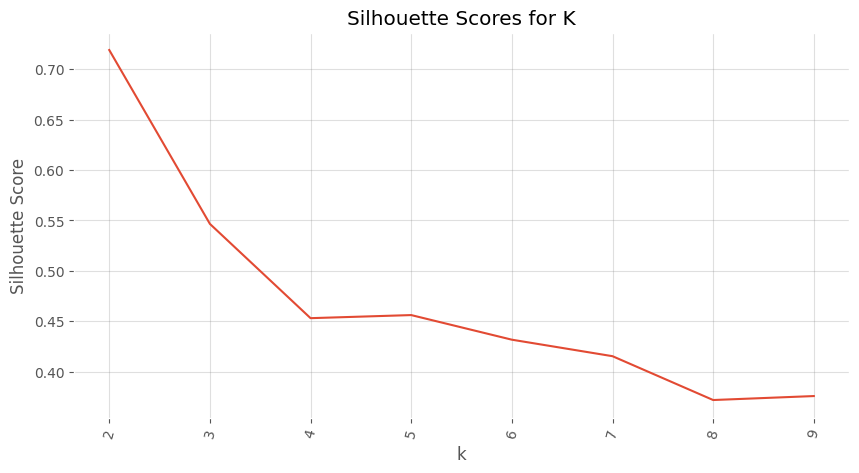

In [53]:
scaler, kmeans, train_regimes, train_feat = compute_regime_clusters(
    df_train,
    n_clusters=None,      # auto choose using silhouette
    atr_window=14,
    vol_windows=[20, 60]
)

In [54]:
df_train_macd =\
(
    assign_regimes(
        df_train,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)
df_train_macd

Price            Close        High         Low        Open    Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  regime
Date                                                                                                                                          
2007-01-31  101.366890  101.634855  100.414918  100.577113  91868600  0.561015        1.0         0.006701                    1.056195     1.0
2007-02-01  101.973335  102.008595  101.479725  101.648956  69312400  0.540516        1.0         0.005965                    1.062514     1.0
2007-02-02  102.114426  102.213148  101.811211  102.058011  49607000  0.541905        1.0         0.001383                    1.063984     1.0
2007-02-05  102.142563  102.206025  101.782924  102.036782  45705300  0.529523        1.0         0.000276                    1.064277     1.0
2007-02-06  102.170830  102.269552  101.775941  102.227244  57081300  0.525924        1.0         0.000277                    1.064572     1.0
...                ...         ...         ...         ...       ...       ...        ...              ...                         ...     ...
2021-02-02  357.220428  358.783953  352.323938  355.441588  64450700  0.574037        1.0         0.014041                    3.722068     1.0
2021-02-03  357.501190  359.233230  356.218553  358.053565  52427100  0.616918        1.0         0.000786                    3.724994     1.0
2021-02-04  361.564453  361.611253  357.613542  358.540405  47142600  0.569220        1.0         0.011302                    3.767331     1.0
2021-02-05  362.987488  363.699035  361.517621  363.446262  48669800  0.550051        1.0         0.003928                    3.782158     1.0
2021-02-08  365.609070  365.655870  363.586799  364.448119  38365200  0.546850        1.0         0.007196                    3.809474     1.0

[3531 rows x 10 columns]

In [55]:
regimes = sorted(df_train_macd["regime"].unique())

regime_dfs = { r: df_train_macd[df_train_macd["regime"] == r].copy()
               for r in regimes }

In [56]:
macd_vol_clustering_hyperparam_df =\
(
    run_macd_hyperparam_search_with_regimes(
        df = df_train_macd,
        price_col='Close',
        regimes = regimes,
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file="data/vol_clustering_with_macd.csv"
    )
)
macd_vol_clustering_hyperparam_df

short_ma  long_ma  signal  regime  cumulative_return    sharpe
82           6       55       8     0.0           1.475943  0.356680
261          9       46       6     0.0           1.456667  0.344146
370         10       51       5     0.0           1.456667  0.344146
63           6       46      10     0.0           1.452825  0.346980
361         10       46       6     0.0           1.452825  0.346980
...        ...      ...     ...     ...                ...       ...
1727        16       33      16     1.0           1.144604  0.102168
1719        16       28      20     1.0           1.144345  0.102777
1907        20       28      16     1.0           1.144345  0.102777
1728        16       33      18     1.0           1.119205  0.085856
1827        18       33      16     1.0           1.119205  0.085856

[1980 rows x 6 columns]

In [57]:
best_per_regime = (
    macd_vol_clustering_hyperparam_df
    .sort_values("cumulative_return", ascending=False)
    .groupby("regime")
    .head(1)
    .reset_index(drop=True)
)

print(best_per_regime)


   short_ma  long_ma  signal  regime  cumulative_return    sharpe
0        13       60       6     1.0           2.032481  0.561368
1         6       55       8     0.0           1.475943  0.356680


In [58]:
regime_macd_lookup = {
    row.regime: (row.short_ma, row.long_ma, row.signal)
    for _, row in best_per_regime.iterrows()
}

print(regime_macd_lookup)


{1.0: (13.0, 60.0, 6.0), 0.0: (6.0, 55.0, 8.0)}


In [59]:
vol_clustering_macd_test =\
(
    assign_regimes(
        df_test,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)

vol_clustering_macd_test.head()

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  regime
Date                                                                                                                                           
2021-05-06  393.632874  393.764361  388.570027  390.589519   74321400  0.582286        1.0         0.007954                    1.077367     1.0
2021-05-07  396.497742  397.155264  393.717419  394.403119   67733800  0.596080        1.0         0.007252                    1.085208     1.0
2021-05-10  392.571442  397.080075  392.449328  396.854652   81852400  0.623618        1.0        -0.009952                    1.074462     1.0
2021-05-11  389.067780  390.063436  385.169687  388.025169  116888000  0.604913        1.0        -0.008965                    1.064872     1.0
2021-05-12  380.802002  387.546176  379.477584  386.268740  134811000  0.616665        1.0        -0.021474                    1.042249     1.0

In [60]:
for r in regimes:
    df_r = vol_clustering_macd_test[vol_clustering_macd_test["regime"] == r].copy()
    spans = regime_macd_lookup[r]
    df_r = MACD(df_r, spans, price_col='Close', allow_short=False)
    vol_clustering_macd_test.loc[df_r.index, f"signal_r{r}"] = df_r["signal"]

vol_clustering_macd_test

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  regime  signal_r0.0  signal_r1.0
Date                                                                                                                                                                     
2021-05-06  393.632874  393.764361  388.570027  390.589519   74321400  0.582286        1.0         0.007954                    1.077367     1.0          NaN          NaN
2021-05-07  396.497742  397.155264  393.717419  394.403119   67733800  0.596080        1.0         0.007252                    1.085208     1.0          NaN          NaN
2021-05-10  392.571442  397.080075  392.449328  396.854652   81852400  0.623618        1.0        -0.009952                    1.074462     1.0          NaN          0.0
2021-05-11  389.067780  390.063436  385.169687  388.025169  116888000  0.604913        1.0        -0.008965                    1.064872     1.0          NaN          NaN
2021-05-12  380.802002  387.546176  379.477584  386.268740  134811000  0.616665        1.0        -0.021474                    1.042249     1.0          NaN          NaN
...                ...         ...         ...         ...        ...       ...        ...              ...                         ...     ...          ...          ...
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300  0.605947        1.0        -0.010787                    1.834628     1.0          NaN          NaN
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400  0.599819        1.0         0.000984                    1.836434     1.0          NaN          NaN
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900  0.576945        1.0         0.015484                    1.865091     1.0          NaN          NaN
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400  0.610358        1.0         0.002287                    1.869360     1.0          NaN          NaN
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500  0.608380        1.0         0.000556                    1.870400     1.0          NaN          NaN

[1137 rows x 12 columns]

In [61]:
signal_cols = [col for col in vol_clustering_macd_test.columns if col.startswith("signal_r")]

vol_clustering_macd_test["signal"] =\
(
    vol_clustering_macd_test[signal_cols]
    .bfill(axis=1)
    .iloc[:, 0]
)

vol_clustering_macd_test = generate_position(vol_clustering_macd_test)

positions_df = vol_clustering_macd_test[['positions']].reset_index()

plot = (
    ggplot(positions_df, aes(x='Date', y='positions'))
    + geom_line(color='blue', size=1)
    + labs(
        title='Trading Positions Over Time',
        x='Date',
        y='Position',
        caption='1 = Long, 0 = No Position, -1 = Short'
    )
    + theme(legend_position='top')
    + ggsize(1200, 500)
)

plot.show()

In [62]:
vol_clustering_macd_test = compute_portfolio(
    vol_clustering_macd_test,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)

vol_clustering_macd_test

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  regime  signal_r0.0  signal_r1.0  signal  positions       our_cash  shares  trade_flag  transaction_cost  our_holdings          total  strategy_returns  cumulative_strategy_returns
Date                                                                                                                                                                                                                                                                                                                         
2021-05-06  393.632874  393.764361  388.570027  390.589519   74321400  0.582286        1.0         0.007954                    1.077367     1.0          NaN          NaN     NaN        0.0  100000.000000     0.0         0.0               0.0           0.0  100000.000000               0.0                     1.000000
2021-05-07  396.497742  397.155264  393.717419  394.403119   67733800  0.596080        1.0         0.007252                    1.085208     1.0          NaN          NaN     NaN        0.0  100000.000000     0.0         0.0               0.0           0.0  100000.000000               0.0                     1.000000
2021-05-10  392.571442  397.080075  392.449328  396.854652   81852400  0.623618        1.0        -0.009952                    1.074462     1.0          NaN          0.0     0.0        0.0  100000.000000     0.0         0.0               0.0           0.0  100000.000000               0.0                     1.000000
2021-05-11  389.067780  390.063436  385.169687  388.025169  116888000  0.604913        1.0        -0.008965                    1.064872     1.0          NaN          NaN     NaN        0.0  100000.000000     0.0         0.0               0.0           0.0  100000.000000               0.0                     1.000000
2021-05-12  380.802002  387.546176  379.477584  386.268740  134811000  0.616665        1.0        -0.021474                    1.042249     1.0          NaN          NaN     NaN        0.0  100000.000000     0.0         0.0               0.0           0.0  100000.000000               0.0                     1.000000
...                ...         ...         ...         ...        ...       ...        ...              ...                         ...     ...          ...          ...     ...        ...            ...     ...         ...               ...           ...            ...               ...                          ...
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300  0.605947        1.0        -0.010787                    1.834628     1.0          NaN          NaN     NaN        0.0  111111.208282     0.0         0.0               0.0           0.0  111111.208282               0.0                     1.111112
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400  0.599819        1.0         0.000984                    1.836434     1.0          NaN          NaN     NaN        0.0  111111.208282     0.0         0.0               0.0           0.0  111111.208282               0.0                     1.111112
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900  0.576945        1.0         0.015484                    1.865091     1.0          NaN          NaN     NaN        0.0  111111.208282     0.0         0.0               0.0           0.0  111111.208282               0.0                     1.111112
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400  0.610358        1.0         0.002287                    1.869360     1.0          NaN          NaN     NaN        0.0  111111.208282     0.0         0.0               0.0           0.0  111111.208282               0.0                     1.111112
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500  0.608380        1.0         0.000556                    1.870400     1.0          NaN          NaN     NaN       

In [63]:
(
    plot_cumulative_returns(
        df = vol_clustering_macd_test.reset_index(),
        date_column='Date',
        strategy_column = 'cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )  
)

In [64]:
vol_clustering_macd_metric = \
(
    compute_performance_metrics(
        log_returns=vol_clustering_macd_test['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Volatility-Regime Adaptive MACD'
    )
)
vol_clustering_macd_metric

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Volatility-Regime Adaptive MACD  0.024       0.106         0.165         0.274          0.408         0.143             111111.208              1.111

In [65]:
combined_results.append(vol_clustering_macd_metric)

## <a id = "part110"></a> 1.10 Dual MACD [back to table of contents](#top) 

In [66]:
fast_spans = [3, 10, 16]   
slow_spans = [12, 26, 9]

dual_macd =\
(
    DUAL_MACD(
        df=df_test,
        fast_spans=fast_spans,
        slow_spans=slow_spans,
        price_column="Close",
        allow_short=False,
    )
)

dual_macd.head(5)

Price            Close        High         Low        Open    Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  fast_ewma_short  fast_ewma_long  fast_macd  fast_signal  slow_ewma_short  slow_ewma_long  slow_macd  slow_signal  fast_cross_up  fast_cross_down  dual_macd_signal
Date                                                                                                                                                                                                                                                                                                      
2021-02-09  365.365631  365.964835  364.354510  364.766427  35551100  0.561384        1.0              NaN                    1.000000       365.365631      365.365631   0.000000     0.000000       365.365631      365.365631   0.000000     0.000000          False            False               NaN
2021-02-10  365.206421  367.266149  362.790948  367.116348  59154400  0.542515        1.0        -0.000436                    0.999564       365.259491      365.278065  -0.018575    -0.009868       365.279392      365.282964  -0.003572    -0.001984          False             True               0.0
2021-02-11  365.796204  366.713724  363.352645  366.292407  42913300  0.551160        1.0         0.001614                    1.001178       365.566184      365.486354   0.079830     0.023842       365.481104      365.467366   0.013738     0.004459           True            False               1.0
2021-02-12  367.603241  367.846643  364.916223  364.991138  50593300  0.533409        1.0         0.004928                    1.006124       366.652614      366.183774   0.468841     0.156763       366.150980      366.064463   0.086516     0.032256          False            False               NaN
2021-02-16  367.284851  369.035634  366.563961  368.839004  50972400  0.553148        1.0        -0.000866                    1.005253       366.978930      366.499863   0.479067     0.238276       366.459048      366.347476   0.111572     0.055851          False            False               NaN

In [67]:
dual_macd = generate_position(
    dual_macd,
    signal_column='dual_macd_signal'
)
dual_macd = compute_portfolio(
    dual_macd,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)
dual_macd.tail(5)

Price            Close        High         Low        Open     Volume   ml_prob  ml_signal  passive_returns  cumulative_passive_returns  fast_ewma_short  fast_ewma_long  fast_macd  fast_signal  slow_ewma_short  slow_ewma_long  slow_macd  slow_signal  fast_cross_up  fast_cross_down  dual_macd_signal  positions       our_cash  shares  trade_flag  transaction_cost  our_holdings          total  strategy_returns  cumulative_strategy_returns
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300  0.605947        1.0        -0.010787                    1.834628       674.308719      676.950233  -2.641514     2.281503       676.597220      672.340520   4.256700     5.277353          False            False               NaN        0.0  133949.022614     0.0         0.0               0.0           0.0  133949.022614               0.0                      1.33949
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400  0.599819        1.0         0.000984                    1.836434       672.639345      675.862912  -3.223568     1.633847       675.731489      672.238997   3.492492     4.920380          False            False               NaN        0.0  133949.022614     0.0         0.0               0.0           0.0  133949.022614               0.0                      1.33949
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900  0.576945        1.0         0.015484                    1.865091       677.039674      676.876929   0.162745     1.460776       676.609722      672.920553   3.689168     4.674138          False            False               NaN        0.0  133949.022614     0.0         0.0               0.0           0.0  133949.022614               0.0                      1.33949
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400  0.610358        1.0         0.002287                    1.869360       680.019837      677.990214   2.029622     1.527699       677.592842      673.667179   3.925663     4.524443           True            False               NaN        0.0  133949.022614     0.0         0.0               0.0           0.0  133949.022614               0.0                      1.33949
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500  0.608380        1.0         0.000556                    1.870400       681.699921      678.970176   2.729744     1.669117       678.483174      674.386648   4.096527     4.438860          False            False               NaN        0.0  133949.022614     0.0         0.0               0.0           0.0  133949.022614               0.0                      1.33949

In [68]:
dual_macd_metrics = \
(
    compute_performance_metrics(
        log_returns=dual_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Dual MACD'
    )
)
print(dual_macd_metrics)


            CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Dual MACD  0.063       0.096         0.118         0.692          1.054         0.535             133949.023              1.339


In [69]:
(
    plot_cumulative_returns(
        df =dual_macd.reset_index(),
        passive_column='cumulative_passive_returns',
        strategy_column='cumulative_strategy_returns'
    )
)

In [70]:
combined_results.append(dual_macd_metrics)

## <a id = "part111"></a> 1.11 Daily Return Forecasting [back to table of contents](#top) 

In [71]:
return_period = 1
Y =\
(
    np
    .log(spy['Close']
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name = 'SPY_pred'

Y

Date
2006-11-01   -0.000585
2006-11-02   -0.001756
2006-11-03    0.011216
2006-11-06    0.003830
2006-11-07    0.002162
                ...   
2025-11-06    0.000984
2025-11-07    0.015484
2025-11-10    0.002287
2025-11-11    0.000556
2025-11-12         NaN
Name: SPY_pred, Length: 4788, dtype: float64

In [72]:
lag_periods = [i for i in range(1,11)]
vol_periods = [5,10,20,60,120]
sma_periods = [63]
ema_periods = [10,30]
rsi_periods = [10,30]
stok_periods = [30]
stod_periods = [30]
roc_periods = [30]
atr_periods = [5, 14, 21]


X = create_all_features(
    spy,
    price_column='Close',
    lagged_return_periods=lag_periods,
    vol_periods=vol_periods,
    sma_periods=sma_periods,
    ema_periods=ema_periods,
    rsi_periods=rsi_periods,
    stok_periods=stok_periods,
    stod_periods=stod_periods,
    roc_periods=roc_periods,
    atr_periods=atr_periods
)

X

1DT       2DT       3DT       4DT       5DT       6DT       7DT       8DT       9DT      10DT      VOL5     VOL10     VOL20      VOL60     VOL120       SMA63       EMA10       EMA30      RSI10      RSI30       %K30       %D30     ROC30      ATR5     ATR14     ATR21
Date                                                                                                                                                                                                                                                                                      
2006-11-01       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN        NaN        NaN         NaN   95.973633   95.973633        NaN        NaN        NaN        NaN       NaN       NaN       NaN       NaN
2006-11-02 -0.000585       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN        NaN        NaN         NaN   95.963434   95.970014        NaN        NaN        NaN        NaN       NaN       NaN       NaN       NaN
2006-11-03 -0.001756 -0.002341       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN        NaN        NaN         NaN   95.924491   95.955771        NaN        NaN        NaN        NaN       NaN       NaN       NaN       NaN
2006-11-06  0.011216  0.009459  0.008875       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN        NaN        NaN         NaN   96.088979   96.012120        NaN        NaN        NaN        NaN       NaN       NaN       NaN       NaN
2006-11-07  0.003830  0.015046  0.013290  0.012705       NaN       NaN       NaN       NaN       NaN       NaN  0.640655       NaN       NaN        NaN        NaN         NaN   96.291125   96.088808        NaN        NaN        NaN        NaN       NaN  0.943887       NaN       NaN
...              ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...        ...        ...         ...         ...         ...        ...        ...        ...        ...       ...       ...       ...       ...
2025-11-06 -0.010787 -0.007328 -0.019252 -0.017377 -0.014103 -0.025162 -0.024681 -0.022029 -0.010300 -0.002161  5.279618  5.522733  9.672772  14.154735  29.484253  659.263508  676.950233  670.954578  48.347481  55.109778  47.395490  58.428242  1.282825  7.202014  6.708575  8.335717
2025-11-07  0.000984 -0.009803 -0.006344 -0.018268 -0.016393 -0.013118 -0.024177 -0.023697 -0.021045 -0.009316  5.322515  6.246752  8.503210  14.040407  29.369548  659.847765  675.862912  670.955571  41.999990  53.903012  49.185977  54.566765  1.098418  8.008008  6.855002  8.580479
2025-11-10  0.015484  0.016468  0.005681  0.009140 -0.002784 -0.000909  0.002365 -0.008694 -0.008213 -0.005561  4.646683  5.996522  8.282299  14.064333  29.329377  660.491048  676.876929  671.631986  45.513994  57.001951  77.590849  58.057439  2.290674  9.078015  7.440717  8.109052
2025-11-11  0.002287  0.017770  0.018755  0.007967  0.011427 -0.000498  0.001377  0.004652 -0.006407 -0.005927  5.843574  5.550288  7.942900  14.090886  29.135267  661.124270  677.990214  672.365406  45.190479  56.663409  81.823074  69.533300  2.176676  8.294019  7.165004  7.762864
2025-11-12  0.000556  0.002843  0.018327  0.019311  0.008523  0.011983  0.000059  0.001933  0.005208 -0.005851  6.598741  5.004062  7.718523  13.995565  28.922760  661.762573  678.970176  673.076025  45.258005  55.994161  82.854016  80.755980  2.115901  7.758020  7.100717  7.350958

[4788 rows x 26 columns]

In [73]:
data =\
(
    pd
    .concat([Y, X],
            axis = 1)
    .dropna()
)

Y =\
(
    data
    .loc[ : , Y.name]
)
X =\
(
    data
    .loc[ : , X.columns]
)

In [74]:
SL =\
(
    SupervisedLearning()
)

In [75]:
X_train, X_test, Y_train, Y_test =\
(
    SL
    .sequential_split(X,Y,train_frac=0.75)
    
)

Sequential Split: 3501 train / 1167 test samples


In [76]:
seed = 2025
num_folds = 10

metric = "neg_mean_squared_error"

In [77]:
comparison_df = None;
cache_file = "data/sl_prediction_comparison.csv"

if os.path.exists(cache_file):
    comparison_df = pd.read_csv(cache_file)
else :
    results =\
    (
        SL
        .run_all_models(
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test,
            num_folds = num_folds,
            seed = seed,
            metric = metric
        )
    )
    results['comparison_df'].to_csv(cache_file)
    comparison_df = results['comparison_df']

In [78]:
(
    SL
    .plot_performance(comparison_df)
)

In [79]:
# chosen model
model =\
(
    SL.get_model_by_name("Support Vector Machine")
)

model

SVR()

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [81]:
testing_df =\
(
    spy
    .copy()
    .rename(columns={'Close': "actual_close"})
)
testing_df.loc[X_test.index, "pred_return"] = y_pred
testing_df["pred_close"] =\
(
    testing_df["actual_close"] 
    * np.exp(testing_df["pred_return"])
)
testing_df

actual_close        High         Low        Open     Volume   Adj_Close  pred_return  pred_close
Date                                                                                                        
2006-11-01     95.973633   96.990449   95.875458   96.927339   83005600   95.973633          NaN         NaN
2006-11-02     95.917542   96.078827   95.623016   95.728200   60693100   95.917542          NaN         NaN
2006-11-03     95.749245   96.345315   95.104092   96.261168   71346400   95.749245          NaN         NaN
2006-11-06     96.829178   96.969427   96.036757   96.043777   63303300   96.829178          NaN         NaN
2006-11-07     97.200783   97.460243   96.773018   96.913266   63318900   97.200783          NaN         NaN
...                  ...         ...         ...         ...        ...         ...          ...         ...
2025-11-06    670.309998  677.380005  668.719971  676.469971   85035300  670.309998     0.007020  675.032250
2025-11-07    670.969971  671.080017  661.210022  667.909973  100592400  670.969971     0.007019  675.696178
2025-11-10    681.440002  682.179993  675.030029  677.239990   75842900  681.440002     0.007025  686.243659
2025-11-11    683.000000  683.570007  678.729980  679.950012   58953400  683.000000     0.007029  687.817546
2025-11-12    683.380005  684.960022  680.950012  684.789978   62312500  683.380005          NaN         NaN

[4788 rows x 8 columns]

In [82]:
def generate_signal_simple(df: pd.DataFrame):
    df = df.copy()
    df['signal'] = (df['pred_return'] > 0).astype(int)

    df['positions'] = df['signal'] 
    # no need to shift(1) cause we using predicted returns
    return df

In [83]:
testing_df =\
(
    generate_signal_simple(testing_df)
    .dropna()
)
testing_df =\
(
    compute_cumulative_returns(
        df = testing_df,
        position_column='positions',
        price_column = 'actual_close'
    )
)
testing_df

actual_close        High         Low        Open     Volume   Adj_Close  pred_return  pred_close  signal  positions  passive_returns  strategy_returns  cum_log_returns  cumulative_returns_strategy  cumulative_max_strategy  cumulative_returns_passive
Date                                                                                                                                                                                                                                                                 
2021-03-23    365.857788  369.577413  365.068779  368.121507   90686600  365.857788    -0.011808  361.563075       0          0              NaN               NaN              NaN                          NaN                      NaN                         NaN
2021-03-24    363.997955  368.910510  363.951002  367.266733   97588600  363.997955    -0.011531  359.824767       0          0        -0.005096         -0.000000         0.000000                     1.000000                  1.00000                    0.994917
2021-03-25    366.045685  366.844068  360.597721  362.551483  116128600  366.045685    -0.011526  361.850846       0          0         0.005610          0.000000         0.000000                     1.000000                  1.00000                    1.000514
2021-03-26    371.944489  372.348381  366.599863  367.201000  114409100  371.944489    -0.011810  367.577481       0          0         0.015986          0.000000         0.000000                     1.000000                  1.00000                    1.016637
2021-03-29    371.756531  372.667654  368.966806  370.460291  108107600  371.756531    -0.011598  367.469768       0          0        -0.000505         -0.000000         0.000000                     1.000000                  1.00000                    1.016123
...                  ...         ...         ...         ...        ...         ...          ...         ...     ...        ...              ...               ...              ...                          ...                      ...                         ...
2025-11-05    677.580017  680.859985  674.169983  674.979980   74402400  677.580017     0.007025  682.356672       1          1         0.003459          0.003459         0.361140                     1.434965                  1.45574                    1.852031
2025-11-06    670.309998  677.380005  668.719971  676.469971   85035300  670.309998     0.007020  675.032250       1          1        -0.010787         -0.010787         0.350353                     1.419569                  1.45574                    1.832160
2025-11-07    670.969971  671.080017  661.210022  667.909973  100592400  670.969971     0.007019  675.696178       1          1         0.000984          0.000984         0.351337                     1.420966                  1.45574                    1.833964
2025-11-10    681.440002  682.179993  675.030029  677.239990   75842900  681.440002     0.007025  686.243659       1          1         0.015484          0.015484         0.366821                     1.443139                  1.45574                    1.862582
2025-11-11    683.000000  683.570007  678.729980  679.950012   58953400  683.000000     0.007029  687.817546       1          1         0.002287          0.002287         0.369108                     1.446443                  1.45574                    1.866846

[1167 rows x 16 columns]

<Axes: xlabel='Date'>

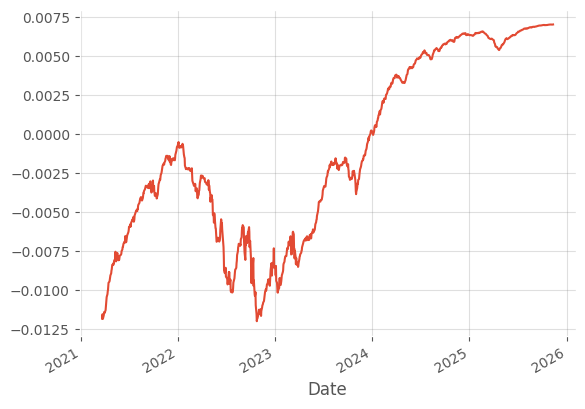

In [84]:
testing_df['pred_return'].plot()

In [85]:
ml_pred_returns_metrics =\
(
    compute_performance_metrics(
        log_returns=testing_df['strategy_returns'],
        initial_capital=100_000,
        strategy='Daily Returns Forecasting'
    )
)

ml_pred_returns_metrics

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Daily Returns Forecasting  0.083       0.106         0.188         0.808          1.255         0.442              144644.32              1.446

In [86]:
combined_results.append(ml_pred_returns_metrics)

## 👇 <a id = "part2"></a><font color = blue> 👉 Part 2 - Results of Strategies </font> [back to table of contents](#top)

In [87]:
comparison_df=\
(
    pd.concat(
        combined_results,
        axis=0
    )
    .sort_values(by='Final Portfolio Value', ascending=False)
)

comparison_df

CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Final Portfolio Value  Cumulative Return
Mean_Reversion_C (SMA Pct Dist + Candle Counts)  0.150       0.125         0.101         1.185          1.406         1.485             194358.821              1.944
Mean_Reversion_A (SMA, Std, BB)                  0.141       0.113         0.116         1.232          1.047         1.219             187594.999              1.876
Buy and Hold                                     0.141       0.173         0.245         0.850          1.403         0.574             187040.035              1.870
Adaptive MACD                                    0.139       0.173         0.245         0.843          1.391         0.569             185891.280              1.859
ML-Enhanced Adaptive SMA                         0.136       0.106         0.123         1.256          2.023         1.105             183489.215              1.835
Adaptive Risk-Adjusted SMA                       0.114       0.106         0.105         1.073          1.690         1.094             167399.436              1.674
Adaptive EMA                                     0.089       0.129         0.270         0.731          1.128         0.331             150208.051              1.502
Daily Returns Forecasting                        0.083       0.106         0.188         0.808          1.255         0.442             144644.320              1.446
Dual MACD                                        0.063       0.096         0.118         0.692          1.054         0.535             133949.023              1.339
Mean_Reversion_B (RSI)                           0.062       0.107         0.107         0.617          0.629         0.580             133141.099              1.331
Baseline MACD                                    0.043       0.107         0.164         0.449          0.671         0.264             122363.759              1.224
Volatility-Regime Adaptive MACD                  0.024       0.106         0.165         0.274          0.408         0.143             111111.208              1.111

In [88]:
comparison_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, Mean_Reversion_C (SMA Pct Dist + Candle Counts) to Volatility-Regime Adaptive MACD
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAGR                   12 non-null     float64
 1   Volatility             12 non-null     float64
 2   Max Drawdown           12 non-null     float64
 3   Sharpe Ratio           12 non-null     float64
 4   Sortino Ratio          12 non-null     float64
 5   Calmar Ratio           12 non-null     float64
 6   Final Portfolio Value  12 non-null     float64
 7   Cumulative Return      12 non-null     float64
dtypes: float64(8)
memory usage: 864.0+ bytes


In [89]:
comparison_df.to_csv('data/combined_results.csv')

#### Based on cumulative returns, we can see that the Mean Reversion C and A managed to beat the market

In [90]:
print(comparison_df['Cumulative Return'])

Mean_Reversion_C (SMA Pct Dist + Candle Counts)    1.944
Mean_Reversion_A (SMA, Std, BB)                    1.876
Buy and Hold                                       1.870
Adaptive MACD                                      1.859
ML-Enhanced Adaptive SMA                           1.835
Adaptive Risk-Adjusted SMA                         1.674
Adaptive EMA                                       1.502
Daily Returns Forecasting                          1.446
Dual MACD                                          1.339
Mean_Reversion_B (RSI)                             1.331
Baseline MACD                                      1.224
Volatility-Regime Adaptive MACD                    1.111
Name: Cumulative Return, dtype: float64


In [91]:
comparison_df.index.name = "Strategy"
df_plot = comparison_df.reset_index()

In [92]:
p_final = (
    ggplot(df_plot, aes(x="Strategy", y="Final Portfolio Value", fill="Strategy"))
    + geom_bar(stat="identity", width=0.6)
    + theme_minimal()
    + ggsize(2000, 1000)
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title="Final Portfolio Value", y="Value ($)", x="")
)
p_final.show()

In [93]:
p_sharpe = (
    ggplot(df_plot, aes(x="Strategy", y="Sharpe Ratio", fill="Strategy"))
    + geom_bar(stat="identity", width=0.6)
    + theme_minimal()
    + ggsize(2000, 1000)
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title="Sharpe Ratio Comparison", y="Sharpe Ratio", x="")
)
p_sharpe.show()

In [94]:
p_cagr = (
    ggplot(df_plot, aes(x="Strategy", y="CAGR", fill="Strategy"))
    + geom_bar(stat="identity", width=0.6)
    + theme_minimal()
    + ggsize(2000, 1000)
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title="CAGR Comparison", y="CAGR", x="")
)
p_cagr.show()

## The Risk–Return Map helps visualize how each trading strategy performs when we compare return vs risk.

X-axis = Volatility (Risk)
Higher volatility means the strategy swings more and is less stable.

Y-axis = CAGR (Annualized Return)
Higher CAGR means the strategy grows faster over time.

Point size = Final Portfolio Value
Bigger point → more money at the end.

Point color = Sharpe Ratio
Brighter color → better risk-adjusted performance.

---

Upper-left area = best zone
High return + low risk. These are the most efficient strategies.

Upper-right = high return but also high risk
Potentially good, but comes with volatility.

Lower-left = stable but low performance
Safe, but doesn’t grow much.

Lower-right = worst zone
Low return + high risk → avoid.

In [95]:

tooltip = layer_tooltips().title("@Strategy")

# Create the chart
p_risk_return = (
    ggplot(df_plot, aes(x="Volatility", y="CAGR"))
    + geom_point(
        aes(
            size="Final Portfolio Value",
            color="Sharpe Ratio"
        ),
        alpha=0.85,
        tooltips=tooltip
    )
    + scale_size(range=[6, 20])
    + theme_minimal()
    + ggsize(1000, 550)
    + labs(
        title="Risk–Return Map of Trading Strategies",
        x="Volatility (Risk)",
        y="CAGR (Annualized Return)"
    )
)

p_risk_return.show()

## 👇 <a id = "part3"></a><font color = blue> Part 3 - Executive Summary</font> [back to table of contents](#top)

## <a id = "part31"></a> 3.1 Voting System [back to table of contents](#top) 

In [96]:
metric_sort_order = {
    "CAGR": False,
    "Volatility": True,
    "Max Drawdown": True,
    "Sharpe Ratio": False,
    "Sortino Ratio": False,
    "Calmar Ratio": False,
    "Final Portfolio Value": False,
    "Cumulative Return": False,
}


In [97]:
winners = []

metric_winners = {}  
votes = []           

for metric, ascending in metric_sort_order.items():
    winner = (
        comparison_df
        .sort_values(by=metric, ascending=ascending)
        .index[0]
    )
    metric_winners[metric] = winner
    votes.append(winner)

# Count votes across all metrics
winner_counts = pd.Series(votes).value_counts()

metric_winners

{'CAGR': 'Mean_Reversion_C (SMA Pct Dist + Candle Counts)',
 'Volatility': 'Dual MACD',
 'Max Drawdown': 'Mean_Reversion_C (SMA Pct Dist + Candle Counts)',
 'Sharpe Ratio': 'ML-Enhanced Adaptive SMA',
 'Sortino Ratio': 'ML-Enhanced Adaptive SMA',
 'Calmar Ratio': 'Mean_Reversion_C (SMA Pct Dist + Candle Counts)',
 'Final Portfolio Value': 'Mean_Reversion_C (SMA Pct Dist + Candle Counts)',
 'Cumulative Return': 'Mean_Reversion_C (SMA Pct Dist + Candle Counts)'}

In [98]:
print(winner_counts)

Mean_Reversion_C (SMA Pct Dist + Candle Counts)    5
ML-Enhanced Adaptive SMA                           2
Dual MACD                                          1
Name: count, dtype: int64


In [99]:
(
    comparison_df['Cumulative Return']
    .sort_values(ascending=False)
).head(3)

Strategy
Mean_Reversion_C (SMA Pct Dist + Candle Counts)    1.944
Mean_Reversion_A (SMA, Std, BB)                    1.876
Buy and Hold                                       1.870
Name: Cumulative Return, dtype: float64

## <a id = "part32"></a> 3.2 Executive Summary [back to table of contents](#top) 

> ### Overall

We can essentially break down the strategies into different types (excluding buy and hold)
- 1. Momentum 
- 2. Mean Reversion
- 3. Machine Learning


> ## Momentum Strategy Review

1. Baseline momentum strategy

Strategy Logic: The system generates a buy signal when the 20-day MA crosses above the 80-day MA, indicating upward momentum, and a sell signal when it crosses below, suggesting downward momentum. This crossover approach aims to capture trending market movements while avoiding sideways market noise.

Position Sizing Analysis: The project compares two distinct approaches:

Fixed Position Sizing: Uses a constant 8 shares per trade[8 is an arbitrary number], resulting in a final portfolio value of $126,732 or 26.73% return 
Risk-Based Position Sizing: Allocates 10% of current portfolio value per trade, achieving $111,852 (11.85% return)

Performance Metrics: Both approaches show identical Sharpe ratios (0.49), but the risk-based method demonstrates superior risk management with significantly lower volatility (1.23% vs 2.64%) and maximum drawdown (-3.31% vs -9.29%). The fixed approach generates higher absolute returns but with substantially increased risk.

Issues we faced/approaches that could be sharpen:
- Which Moving average pair should we incorporate: Since we are testing on the last 25% of the timeframe, we wanted trades to be executed more often. Whereas, if the MA's were far greater (say 100,200 MA), would equate to fewer trade opportunities.
- Transaction costs not considered: Our analysis assumes zero transaction costs, but in reality, each buy/sell would incur brokerage fees and bid-ask spreads, which could significantly impact the strategy's profitability, especially with frequent trading.
- Lagging nature of moving averages: The crossover signals inherently lag behind actual trend changes, meaning we often enter positions after significant price movements have already occurred, potentially missing optimal entry/exit points.
- Risk management limitations: The strategy lacks stop-loss mechanisms or position sizing based on volatility, making it vulnerable to prolonged drawdowns during volatile market periods or false breakouts.
- Market regime sensitivity: The 20/80 MA combination may perform differently across various market conditions (bull, bear, sideways), suggesting the need for adaptive parameters or regime-detection mechanisms.
- Optimization and overfitting risk: While we tested 20/80 MA, more systematic parameter optimization across different MA combinations could improve performance, though this risks overfitting to historical data. 

### [1.4 ML-Enhanced Adaptive SMA](#part14)

Strategy Logic:
The strategy first generates a trend signal using an SMA crossover. A long (or short) position is only taken when the SMA signal is confirmed by the logistic classifier — specifically when the model predicts that the next-period return will be positive (for long) or negative (for short). The ML model acts as a confirmation filter to reduce false signals and adapt to changing market regimes.

### [1.5 Adaptive Risk-Adjusted SMA](#part15)

Strategy Logic:
This strategy applies an SMA crossover as the core signal, but adjusts position sizes dynamically based on market volatility. When volatility is high, the position size is reduced; when volatility is low, the size is increased.
A logistic ML model acts as an additional filter — trades are only taken when the model predicts a favorable return. This creates a more risk-aware version of the SMA strategy by combining trend detection, ML filtering, and volatility-based position sizing.

### [1.6 Adaptive EMA](#part16)

Strategy Logic: Adaptive EMA uses an EMA crossover system where both the short-term and long-term EMA windows were optimized on the training set. The tuning process searches for the parameter pair that maximizes performance (e.g., CAGR, Sharpe). These optimized EMAs are then applied to the test period for signal generation.

### [1.7 Baseline MACD](#part17)

The baseline MACD strategy uses the conventional MACD parameters:
fast = 12, slow = 26, signal = 9.
Signals are generated using the standard MACD line crossing its signal line. This serves as the classical momentum benchmark without any tuning or adaptation.

### [1.8 Adaptive MACD](#part18)

The Adaptive MACD strategy optimizes the MACD hyperparameters on the training set.
Instead of using fixed spans, the model performs a parameter search over fast, slow, and signal window sizes to find the combination that maximizes performance (e.g., Sharpe, CAGR).
These optimized parameters are then applied to the test set to generate signals.

### [1.9 Volatility-Regime Adaptive MACD](#part19)

This strategy combines regime detection with hyperparameter tuning.
Volatility regimes are first identified using K-Means clustering on volatility features.
For each volatility regime, a separate set of MACD parameters is optimized — meaning high-volatility and low-volatility markets each get their own tailored MACD configuration.
During live execution, the current regime determines which MACD model and parameters to apply.

### [1.10 Dual MACD](#part110)

The Dual MACD strategy uses two MACD configurations simultaneously — a fast MACD and a slow MACD — to improve trend confirmation.

Fast MACD spans: [3, 10, 16]

Slow MACD spans: [12, 26, 9]

The fast MACD reacts quickly to momentum shifts, while the slow MACD provides a stability filter.
A trade is only taken when the fast MACD generates a signal and the slow MACD agrees, reducing noise and improving reliability.


> ## Mean Reversion

This project implements a sophisticated mean reversion trading strategy framework on the S&P 500 (SPY) from 2006 to 2025, enhanced with volatility-regime adaptation through unsupervised machine learning. At the core of the system is a K-Means clustering model trained on five-day volatility features, including realized volatility, ATR percentage, volume ratios, and range compression, to classify market conditions into five distinct volatility regimes. The clustering model is fitted only on the first 75% of the dataset and applied to the remaining test set without refitting, ensuring clean out-of-sample evaluation and avoiding look-ahead bias. Regimes are automatically ordered from calm to crisis severity, and the choice of k=5 is validated through silhouette scoring.

Within this adaptive framework, the first strategy uses a fully dynamic Z score mean reversion model that adjusts its rolling averages, volatility estimates, and signal thresholds according to each volatility regime. Long trades occur when the Z score falls below a regime specific lower bound, short trades when it rises above an upper bound, and positions close once price returns to the mean. All parameters are dynamically tuned per regime through a Sharpe based grid search. The second and third strategies follow the same dynamic structure using RSI and SMA percentage distance signals. The RSI model buys when RSI recovers from oversold and sells when it retreats from overbought, exiting at the neutral level of 50. The SMA percentage distance model requires a dynamic deviation from the SMA together with a short persistence filter across a few candles, which helps filter noise and improve accuracy.

Across all strategies, the system follows a rigorous implementation pipeline, featuring a 75/25 temporal train-test split, regime-specific hyperparameter searches performed with joblib, and capital-based execution that allocates 98% of capital to each long or short position. Performance is evaluated using total return, CAGR, the Sharpe ratio, maximum drawdown, and directional win rates, supported by a broad set of visualizations that include regime overlays, trade-by-trade charts, and drawdown analyses. The core innovation lies in the regime-adaptive parameter selection, allowing each strategy to tighten its settings during stable, low-volatility environments and widen them during high-volatility periods, which greatly improves robustness across major market events such as the 2008 financial crisis and the COVID-19 volatility shock.

The performance analysis reveals that both the SMA Percentage-Distance strategy (Mean Reversion C) outperform the SPY benchmark across all major performance dimensions. Mean Reversion C achieves a CAGR of 15.0%, Sharpe ratio of 1.185, and a cumulative return of 1.94×, while Mean Reversion A delivers a CAGR of 14.1%, Sharpe ratio of 1.232, and a cumulative return of 1.87 exceeding the long-run SPY baseline. Both strategies therefore nearly double the initial capital, surpassing the performance of the underlying index.


### [1.1 Mean Reversion A - Dynamic SMA, Std, BB + Regime ATR & Volatility Clustering](#part1_1)

Strategy Logic:
This strategy integrates unsupervised learning with classical statistical mean reversion. Volatility regimes are identified using K-Means clustering on 5-day microstructural features (realized volatility, ATR%, volume ratio, price range), with the clustering model trained only on the training dataset. The regime classifier is then applied dynamically to the full timeline to label evolving volatility conditions in real time.

Trading signals follow a dynamic Z-score (Bollinger-style) mean-reversion rule:

- Long entries when price drops >2σ below the rolling SMA.
- Short entries when price rises >2σ above the SMA.
- Exits when the Z-score mean-reverts toward zero.

The regime layer acts as a dynamic filter, activating trades only under selected volatility states. All hyperparameters, SMA window, lookback length, Z-thresholds, regime filters, are tuned through a parallelized grid search on training data only, and then applied dynamically during out-of-sample testing.


### [1.2 Mean Reversion B - Dynamic RSI + Regime ATR & Volatility Clustering](#part1_2)

Strategy Logic:
This strategy replaces the prior signal framework with a purely RSI-based mean-reversion system, while retaining the same K-Means volatility-regime architecture.RSI is computed using a standard rolling-gain/rolling-loss formulation over a configurable lookback period.

- Long entries are generated when RSI exits the oversold zone (crosses above 30), signalling a potential upward reversal.
- Short entries are generated when RSI exits the overbought zone (crosses below 70), indicating a potential downward reversal.
- Exits occur when RSI reverts toward the neutral zone (crosses 50).

The K-Means clustering layer identifies volatility regimes using 5-day microstructural features (volatility, ATR%, volume ratio, price range), enabling regime-filtered execution. All hyperparameters, RSI lookback length, threshold levels, and volatility-regime selection, are optimized strictly on training data only.

### [1.3 Mean Reversion C - Dynamic SMA Percentage Distance, Candle Counts + Regime ATR & Volatility Clustering](#part1_3)

Strategy Logic:
This strategy generates signals using the percentage deviation from the SMA, combined with a consecutive-candle persistence filter for confirmation. Long entries occur when price declines beyond a specified percentage below the SMA (e.g., 2%) and remains below the SMA for a minimum number of consecutive candles (default: 3). Short entries follow the symmetric rule: price must rise above the SMA by the threshold percentage and stay above it for the required candle count. Exits are triggered once price reverts back toward the mean (percentage deviation crosses zero).

The consecutive-candle condition reduces noise by filtering out transient deviations and short-lived whipsaws, ensuring trades are taken only when the displacement from the SMA is sustained. A K-Means volatility-regime layer, trained on 5-day microstructural features, enables regime-filtered execution. All hyperparameters: SMA window, percentage thresholds, and minimum candle count are tuned using training data only.



> ## <bold> Machine-Learning Review </bold>

We predicted daily and weekly (5-day log returns) using supervised learning models, incorporating features from S&P 500 price and volume data.

While our machine learning strategies seemed promising when tested on the training data, they ran into real problems when faced with new, unseen data. The best results, at least by RMSE, came from linear models like Linear Regression, LASSO, and Elastic Net, as well as K-Nearest Neighbors. But in practice, these models didn’t give us useful or realistic trading signals. 

The linear models tended to make almost the same prediction over and over—usually a small, positive value—so the strategy basically just bought and held the index. In fact, our actual trading rule was simple: buy when the model predicted returns above zero, and otherwise just hold. But since the predictions rarely dropped below zero, we ended up almost always in a buy position, which didn’t really add any practical value over a basic buy-and-hold approach. 

That’s a sign the models couldn’t find meaningful patterns in the data, probably because predicting daily S&P 500 returns is extremely tough, with very little signal compared to the noise. K-Nearest Neighbors, meanwhile, made predictions that hovered around zero, with the occasional odd spike—likely just picking up on random noise rather than anything real. 

These problems point to bigger challenges: risks of using future information by accident (lookahead bias), models that break down when the market changes, and the fact that stock index returns are notoriously hard to predict and often behave almost randomly. 

There are also issues like possible survivorship bias in our data, overfitting to features, and assuming that past relationships will hold in the future—even when economic conditions shift, which is highly likely for our case, as we had a long prediction period of almost 5 years, and also we were unable to use macroeconomic features that could have possibly helped with the better prediction

## <a id = "part33"></a> 3.3 Top 3 Strategies [back to table of contents](#top) 

Based on the winner count voting, we have these 3 strategies

In [100]:
print(winner_counts)

Mean_Reversion_C (SMA Pct Dist + Candle Counts)    5
ML-Enhanced Adaptive SMA                           2
Dual MACD                                          1
Name: count, dtype: int64


### [1.3 Mean Reversion C - Dynamic SMA Percentage Distance, Candle Counts + Regime ATR & Volatility Clustering](#part1_3)

This strategy achieved top performance in 5 out of 8 categories:

- CAGR

- Max Drawdown

- Calmar Ratio

- Final Portfolio Value

- Cumulative Return

It also outperformed the SPY benchmark, delivering higher long-term growth and stronger downside protection. Although it did not lead in Sharpe Ratio, Sortino Ratio, or Volatility, its dominance in return-focused metrics highlights its ability to generate superior absolute performance with controlled drawdowns. Overall, this strategy captures regime-aware mean reversion opportunities effectively, translating into robust capital appreciation over the test period.

### [1.4 ML-Enhanced Adaptive SMA](#part14)

This strategy managed to win in 2 categories

1. Sharpe Ratio
2. Sortino Ratio

This indicates the strategy is especially good at risk-adjusted performance: the ML filter removes poor trades, making the return distribution smoother, even if total CAGR is slightly lower than the top strategy.

### [1.10 Dual MACD](#part110)

This strategy won in this category:

1. Volatility (lowest overall volatility)

Dual MACD uses confirmation from a slower MACD, significantly reducing whipsaws — hence lower volatility. this is also because it had low number of trades happening, resulting in less movement of the portfolio

While it does not have the highest absolute return metrics, it is a stable, smoother strategy.

### [1.1 Mean Reversion A - Dynamic SMA, Std, BB + Regime ATR & Volatility Clustering](#part1_1)

we also want to special mention this strategy as it also mananged to beat the buy and hold strategy

## 👇 <a id = "part4"></a><font color = blue> Part 4 - Self-Critique</font> [back to table of contents](#top)

### Momentum Strategy

Although the strategy generated positive returns, several limitations reduced its overall robustness. The moving-average crossover framework is inherently lagging, often triggering entries only after a trend has already taken shape and exits only after a significant portion of a reversal has unfolded. This delay weakens the strategy’s ability to capture turning points and increases susceptibility to whipsaws during sideways or choppy market conditions.
The selection of the 20/80 MA combination was also not derived from systematic parameter exploration. Prioritizing higher trade frequency over a broader, data-driven search likely introduced bias. Furthermore, the backtest assumed zero transaction costs, which is unrealistic and would meaningfully erode performance for a strategy that trades relatively often. Both position-sizing approaches—fixed shares and a simple risk-based method—lacked volatility sensitivity and failed to adjust exposure during periods of heightened market stress.
Additionally, the strategy omitted key risk-management tools such as stop-losses, trailing exits, and regime-adaptation mechanisms, leaving it vulnerable to sharp drawdowns and structural market shifts. Finally, because performance is highly regime-dependent and no walk-forward validation was conducted, the risk of overfitting remains material.


### ML-Enhanced Adaptive SMA

While the use of a logistic classifier introduces intelligence into signal confirmation, ML-based strategies face their own pitfalls. The model may capture noise rather than genuine predictive structure, especially if the feature set is small or highly correlated. ML predictions rely on stationary relationships, but market dynamics evolve, causing ML filters to degrade unexpectedly when exposed to new regimes. Without out-of-sample cross-validation or walk-forward retraining, the strategy risks both lookahead bias (if features were not fully point-in-time) and model drift. Moreover, using ML as a filter can reduce trade frequency to the point where statistical confidence becomes weaker.

### Adaptive Risk-Adjusted SMA and Adaptive EMA

Although volatility-adjusted position sizing improves risk management, the method assumes that historical volatility is a reliable proxy for future risk. During sudden volatility spikes or regime flips, the sizing mechanism may react too slowly, leading to inappropriate exposure. Additionally, the combination of SMA crossover logic and ML confirmation introduces multiple layers of potential overfitting. A volatility-scaling rule calibrated on past data may not generalize well, especially in markets where volatility clusters or dissipates unpredictably. High complexity relative to the number of trades increases model fragility.

### Adaptive MACD

Even though the strategy tunes MACD parameters, optimizing fast/slow spans increases the risk of curve-fitting, especially when the search space is wide. MACD remains sensitive to noise and performs poorly in sideways markets. Parameter sets that appear optimal in the training period may degrade substantially when regime dynamics shift. Without walk-forward re-optimization, the strategy may fail to adjust to new volatility patterns, structural breaks, or changes in trend persistence.

### Volatility-Regime Adaptive MACD

This approach adds sophistication but also adds significant complexity. Tuning MACD parameters separately for each volatility cluster increases the risk of regime-specific overfitting, particularly if the number of samples in certain clusters is small. K-Means clustering assumes stable and well-separated regimes, but real markets often transition gradually rather than discretely. If regime identification lags behind actual market conditions, the strategy may apply parameters that are inappropriate for the current environment. Complexity also reduces interpretability and increases fragility.

## 👇 <a id = "part4"></a><font color = blue> Part 5 - Contribution Statement</font> [back to table of contents](#top)

Contribution Statement


> #### Mikhail 
I contributed to both the technical implementation and comprehensive documentation of our quantitative finance project. My primary technical contribution was the momentum trading strategy using moving average crossovers on the S&P 500 index. I developed and analyzed a 20-day/80-day moving average crossover system, implementing two distinct position sizing approaches: fixed 8-share allocation and dynamic risk-based sizing using 10% of portfolio value per trade.

The momentum strategy analysis included comprehensive performance metrics calculation (Sharpe ratio, CAGR, maximum drawdown) and specialized examination of the last 25% timeframe with normalized $100K starting values. I demonstrated that while the fixed approach achieved higher absolute returns (26.73%), the risk-based method provided superior risk management with significantly lower volatility and drawdown.

Beyond technical implementation, I authored the Executive Summary (Part 3) of our combined notebook, providing detailed analysis of all three strategies: machine learning, momentum, and mean reversion. This comprehensive documentation includes strategy methodology explanations, performance comparisons, limitations analysis, and actionable insights for each approach, synthesizing our team's collective findings into a cohesive strategic overview for stakeholders.


> #### Jun Hao

I contributed primarily to the machine learning and momentum-based components of the project. My work began with developing the daily return forecasting model, where I implemented a baseline approach and subsequently improved it using a logistic regression classifier. I conducted threshold analysis to identify the optimal probability cutoff for directional predictions and incorporated K-Means volatility clustering to explore regime-dependent behavior in forecast performance.

Building on these tools, I designed and implemented several ML-enhanced technical strategies, including the ML-Enhanced Adaptive SMA and Adaptive Risk-Adjusted SMA, integrating model predictions directly into the trading logic. I also performed systematic hyperparameter tuning for both EMA and SMA strategies to identify optimal moving-average spans based on training-set performance.

On the momentum side, I developed the full suite of MACD strategies:

- Baseline MACD
- Adaptive MACD
- Volatility-Regime Adaptive MACD (using K-Means clustering for regime segmentation)
- Dual MACD (fast + slow confirmation)

In addition to strategy development, I contributed substantially to the technical organization of the final submission. I helped compile, structure, and streamline the entire Jupyter Notebook for clarity and flow, ensuring all sections were consistently formatted and easy to navigate. I also generated multiple performance visualizations in Part 2 to clearly present comparative results across strategies.

Overall, my contributions span machine learning model development, regime detection, momentum strategy design, hyperparameter optimization, and notebook integration.

> #### Christopher

I contributed primarily to the visualisation and strategy-development components of the project. I converted most of our performance plots into ggplot, which helped standardise the formatting and improve the clarity of the notebook. I also tested our machine learning approach using rolling-window retraining as a robustness check. Although these results were not included in the final deliverable due to assignment constraints, the exercise helped our team better understand the limitations of the ML model and supported the executive summary.

In terms of strategy development, I implemented the Adaptive Risk-Adjusted SMA, using my teammate’s logistic-regression classifier as the core signal filter. This required hyper-tuning the SMA parameters and adding dynamic volatility-based position sizing to improve risk control. I also collaborated closely with my teammate on the ML-Enhanced Adaptive SMA, contributing to both the refinement of the signal logic and the integration of ML predictions into the trading framework.


> #### Lew Gao Wei (Victor)

I contributed primarily to the research and implementation of the project’s mean-reversion & regime-aware trading system, covering volatility classification, three mean-reversion strategies, large-scale hyperparameter research, dynamic parameter switching, and a complete backtesting + visualization framework.

For the mean reversion strategy, I developed a K-Means volatility regime classifier using a rich feature set: 7 rolling-window volatility measures, 6 ATR features, and liquidity/volume-ratio metrics. After StandardScaler normalization (fit only on training data to prevent look-ahead bias), I validated cluster count using both Elbow and Silhouette methods, selecting k=5 volatility regimes—Calm, Stable, Normal, Elevated, and Crisis. The classifier was trained exclusively on the training dataset and applied to the test set without refitting to ensure out-of-sample integrity.

I implemented three regime-aware mean reversion strategies as follows:

1. Mean Reversion A — Bollinger Z-Score SMA strategy with dynamic window lengths, band widths, and volatility-sensitive z-thresholds.

2. Mean Reversion B — RSI mean reversion strategy regime-adjusted RSI periods/levels, and ATR gating filters to suppress noise in high-vol regimes.

3. Mean Reversion C — SMA percentage-distance + candle-confirmation strategy requiring deviation from SMA plus multi-candle confirmation to reduce false reversals.

For each strategy, I conducted large-scale hyperparameter optimization (>100,000 backtests on various strategies) using joblib parallelization, searching window sizes, ATR Volatility, RSI/Std thresholds, SMA distance bands, and candle confirmation counts. Results were stored per-regime, enabling real-time regime-driven parameter switching where strategies update their parameters daily based on the current volatility regime.

I built a modular backtesting engine with mark-to-market valuation, capital-based allocation, complete P&L decomposition, trade-level win/loss statistics, and comprehensive risk metrics including Sharpe, Sortino, Calmar, annualized volatility, maximum drawdown, and CAGR. 

Beyond the strategy implementation, I also produced numerous visualisations to support our analysis. These included volatility-regime clustering results, entry and exit signal plots for all strategies, RSI distributions, and other exploratory graphics. These visual aids helped the team better understand strategy behavior across different market regimes and contributed to the interpretation of our backtesting results.

Two of the three regime-aware mean-reversion strategies outperformed the SPY buy-and-hold benchmark on out-of-sample test data, showing better risk-adjusted returns and significantly reduced drawdowns in Crisis/Elevated regimes. The volatility-regime classifier proved especially effective by enforcing conservative parameters during high-volatility states.


In [ ]:
%whos

Variable                                                 Type                        Data/Info
----------------------------------------------------------------------------------------------
DUAL_MACD                                                function                    <function DUAL_MACD at 0x000002B94C024B80>
EMA                                                      function                    <function EMA at 0x000002B94C025120>
GGBunch                                                  type                        <class 'lets_plot.plot.plot.GGBunch'>
KMeans                                                   ABCMeta                     <class 'sklearn.cluster._kmeans.KMeans'>
KernelPCA                                                type                        <class 'sklearn.decomposi<...>n._kernel_pca.KernelPCA'>
LetsPlot                                                 type                        <class 'lets_plot.LetsPlot'>
MACD                                                    